In [1]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
from skimage.feature import peak_local_max

import cv2
from skimage.io import imread

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})

BASE_DIR = Path('F:\spatial_data_test\processed')
RUN_ID = '20230523_HCC_PRISM_probe_refined'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
seg_dir = src_dir / 'segmented'
read_dir.mkdir(exist_ok=True)

## read spots

In [2]:
TOPHAT_KERNEL_SIZE = 7
def tophat_spots(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(TOPHAT_KERNEL_SIZE,TOPHAT_KERNEL_SIZE))
    return cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

def extract_coordinates(image, snr=4, quantile=0.96):
    meta = {}
    coordinates = peak_local_max(image,min_distance=2,threshold_abs=snr*np.mean(image))
    meta['Coordinates brighter than given SNR'] = coordinates.shape[0]
    meta['Image mean intensity'] = float(np.mean(image))
    intensities = image[coordinates[:,0],coordinates[:,1]]
    meta[f'{quantile} quantile'] = float(np.quantile(intensities,quantile))
    threshold = np.quantile(intensities,quantile)
    coordinates = coordinates[image[coordinates[:,0],coordinates[:,1]]>threshold]
    meta['Final spots count'] = coordinates.shape[0]
    return coordinates

def find_signal(coordinates,im):
    Maxima = np.zeros(im.shape,dtype=np.uint16)
    Maxima[coordinates[:,0],coordinates[:,1]] = 255
    im[Maxima<=0] = 0 # Mask
    return im

In [3]:
R_test = imread(stc_dir/'cyc_1_cy5.tif')
R_test.shape

(33909, 36118)

In [4]:
QUANTILE = 0.1
kernel = np.ones((5,5), np.uint8)
R_test = imread(stc_dir/'cyc_1_cy5.tif')
R_test = tophat_spots(R_test)
R_test[R_test < 100] = 0
coordinates_R = extract_coordinates(R_test,8,quantile=QUANTILE)
R_test = find_signal(coordinates_R,R_test)
R_test = cv2.dilate(R_test,kernel,iterations=1)

Ye_test = imread(stc_dir/'cyc_1_TxRed.tif')
Ye_test = tophat_spots(Ye_test)
Ye_test[Ye_test < 100] = 0
coordinates_Ye = extract_coordinates(Ye_test,8,quantile=QUANTILE)
Ye_test = find_signal(coordinates_Ye,Ye_test)
Ye_test = cv2.dilate(Ye_test,kernel,iterations=1)

G_test = imread(stc_dir/'cyc_1_cy3.tif')
G_test = tophat_spots(G_test)
G_test[G_test < 100] = 0
coordinates_G = extract_coordinates(G_test,8,quantile=QUANTILE)
G_test = find_signal(coordinates_G,G_test)
G_test = cv2.dilate(G_test,kernel,iterations=1)

B_test = imread(stc_dir/'cyc_1_FAM.tif')
B_test = tophat_spots(B_test)
B_test[B_test < 150] = 0 #100
coordinates_B = extract_coordinates(B_test,8,quantile=QUANTILE)
B_test = find_signal(coordinates_B,B_test)
B_test = cv2.dilate(B_test,kernel,iterations=1)

In [5]:
print("R:", len(coordinates_R),"\nY:", len(coordinates_Ye),"\nG:", len(coordinates_G),"\nB:", len(coordinates_B))

R: 1249109 
Y: 902036 
G: 1231298 
B: 1463703


In [6]:
intensity_R = pd.DataFrame({'Y':coordinates_R[:,0],'X':coordinates_R[:,1]})
intensity_R['R'] = R_test[coordinates_R[:,0],coordinates_R[:,1]]
intensity_R['Ye'] = Ye_test[coordinates_R[:,0],coordinates_R[:,1]]
intensity_R['G'] = G_test[coordinates_R[:,0],coordinates_R[:,1]]
intensity_R['B'] = B_test[coordinates_R[:,0],coordinates_R[:,1]]

intensity_Ye = pd.DataFrame({'Y':coordinates_Ye[:,0],'X':coordinates_Ye[:,1]})
intensity_Ye['R'] = R_test[coordinates_Ye[:,0],coordinates_Ye[:,1]]
intensity_Ye['Ye'] = Ye_test[coordinates_Ye[:,0],coordinates_Ye[:,1]]
intensity_Ye['G'] = G_test[coordinates_Ye[:,0],coordinates_Ye[:,1]]
intensity_Ye['B'] = B_test[coordinates_Ye[:,0],coordinates_Ye[:,1]]

intensity_B = pd.DataFrame({'Y':coordinates_B[:,0],'X':coordinates_B[:,1]})
intensity_B['R'] = R_test[coordinates_B[:,0],coordinates_B[:,1]]
intensity_B['Ye'] = Ye_test[coordinates_B[:,0],coordinates_B[:,1]]
intensity_B['G'] = G_test[coordinates_B[:,0],coordinates_B[:,1]]
intensity_B['B'] = B_test[coordinates_B[:,0],coordinates_B[:,1]]

intensity_G = pd.DataFrame({'Y':coordinates_G[:,0],'X':coordinates_G[:,1]})
intensity_G['R'] = R_test[coordinates_G[:,0],coordinates_G[:,1]]
intensity_G['Ye'] = Ye_test[coordinates_G[:,0],coordinates_G[:,1]]
intensity_G['G'] = G_test[coordinates_G[:,0],coordinates_G[:,1]]
intensity_G['B'] = B_test[coordinates_G[:,0],coordinates_G[:,1]]


# merge datasets
intensity_all = pd.concat([intensity_R,intensity_Ye,intensity_B,intensity_G])#,keys=['R','Ye','B','G'])

In [7]:
intensity_all.to_csv(read_dir/'intensity_all_5x5_not_cross_corrected.csv')

In [3]:
intensity_all = pd.read_csv(read_dir/'intensity_all_5x5_not_cross_corrected.csv').drop(columns='Unnamed: 0')#.drop(columns='Unnamed: 1')#.drop(columns='Unnamed: 2')#,index_col=(0,1))
intensity_all

Y      X      R   Ye     G     B
0         5770   6729  25234    0     0     0
1         2567  27994  12634    0     0     0
2         6484  24166  12073  536  4020  3678
3         8176  24412  11702  579  4090  7296
4         8256  24186  11482  486  3800  3557
...        ...    ...    ...  ...   ...   ...
4846141  24701  11201      0    0   121   294
4846142  18389  30176      0    0   121     0
4846143  11464   7301      0  152   121   349
4846144  15390  29493      0  182   121     0
4846145  26503  19623      0    0   121     0

[4846146 rows x 6 columns]

## correction of intensity

In [4]:
intensity_all = intensity_all.reset_index(drop=True)

#crosstalk elimination
intensity_all['B'] = intensity_all['B'] - intensity_all['G'] * 0.25 #0.35
intensity_all = np.maximum(intensity_all,0)

#Scale
intensity_all['Scaled_R'] = intensity_all['R']
intensity_all['Scaled_Ye'] = intensity_all['Ye']
intensity_all['Scaled_G'] = intensity_all['G'] * 2.5
intensity_all['Scaled_B'] = intensity_all['B'] #* 4/3
intensity_all['sum'] = intensity_all['Scaled_R'] + intensity_all['Scaled_Ye'] + intensity_all['Scaled_B']
intensity_all['sum_G'] = intensity_all['Scaled_R'] + intensity_all['Scaled_Ye'] + intensity_all['Scaled_B'] + intensity_all['Scaled_G']

#filter by sum value (QC)
intensity_all = intensity_all.drop(intensity_all[intensity_all['sum_G'] < 1000].index)
intensity_all = intensity_all.drop(intensity_all[intensity_all['sum'] > 20000].index)
intensity_all['R/A'] = intensity_all['Scaled_R'] / intensity_all['sum']
intensity_all['Ye/A'] = intensity_all['Scaled_Ye'] / intensity_all['sum']
intensity_all['B/A'] = intensity_all['Scaled_B'] / intensity_all['sum']
intensity_all['G/A'] = intensity_all['Scaled_G'] / intensity_all['sum']
intensity_all['X_coor'] = 2*intensity_all['R/A'] - 1
intensity_all['Y_coor'] = intensity_all['B/A'] - intensity_all['Ye/A']

## visualization of spots

[ 39  91 124 158]
[(-0.6, -0.61), (-0.07999999999999996, -0.08999999999999997), (0.25, 0.24), (0.99, 1.0)]


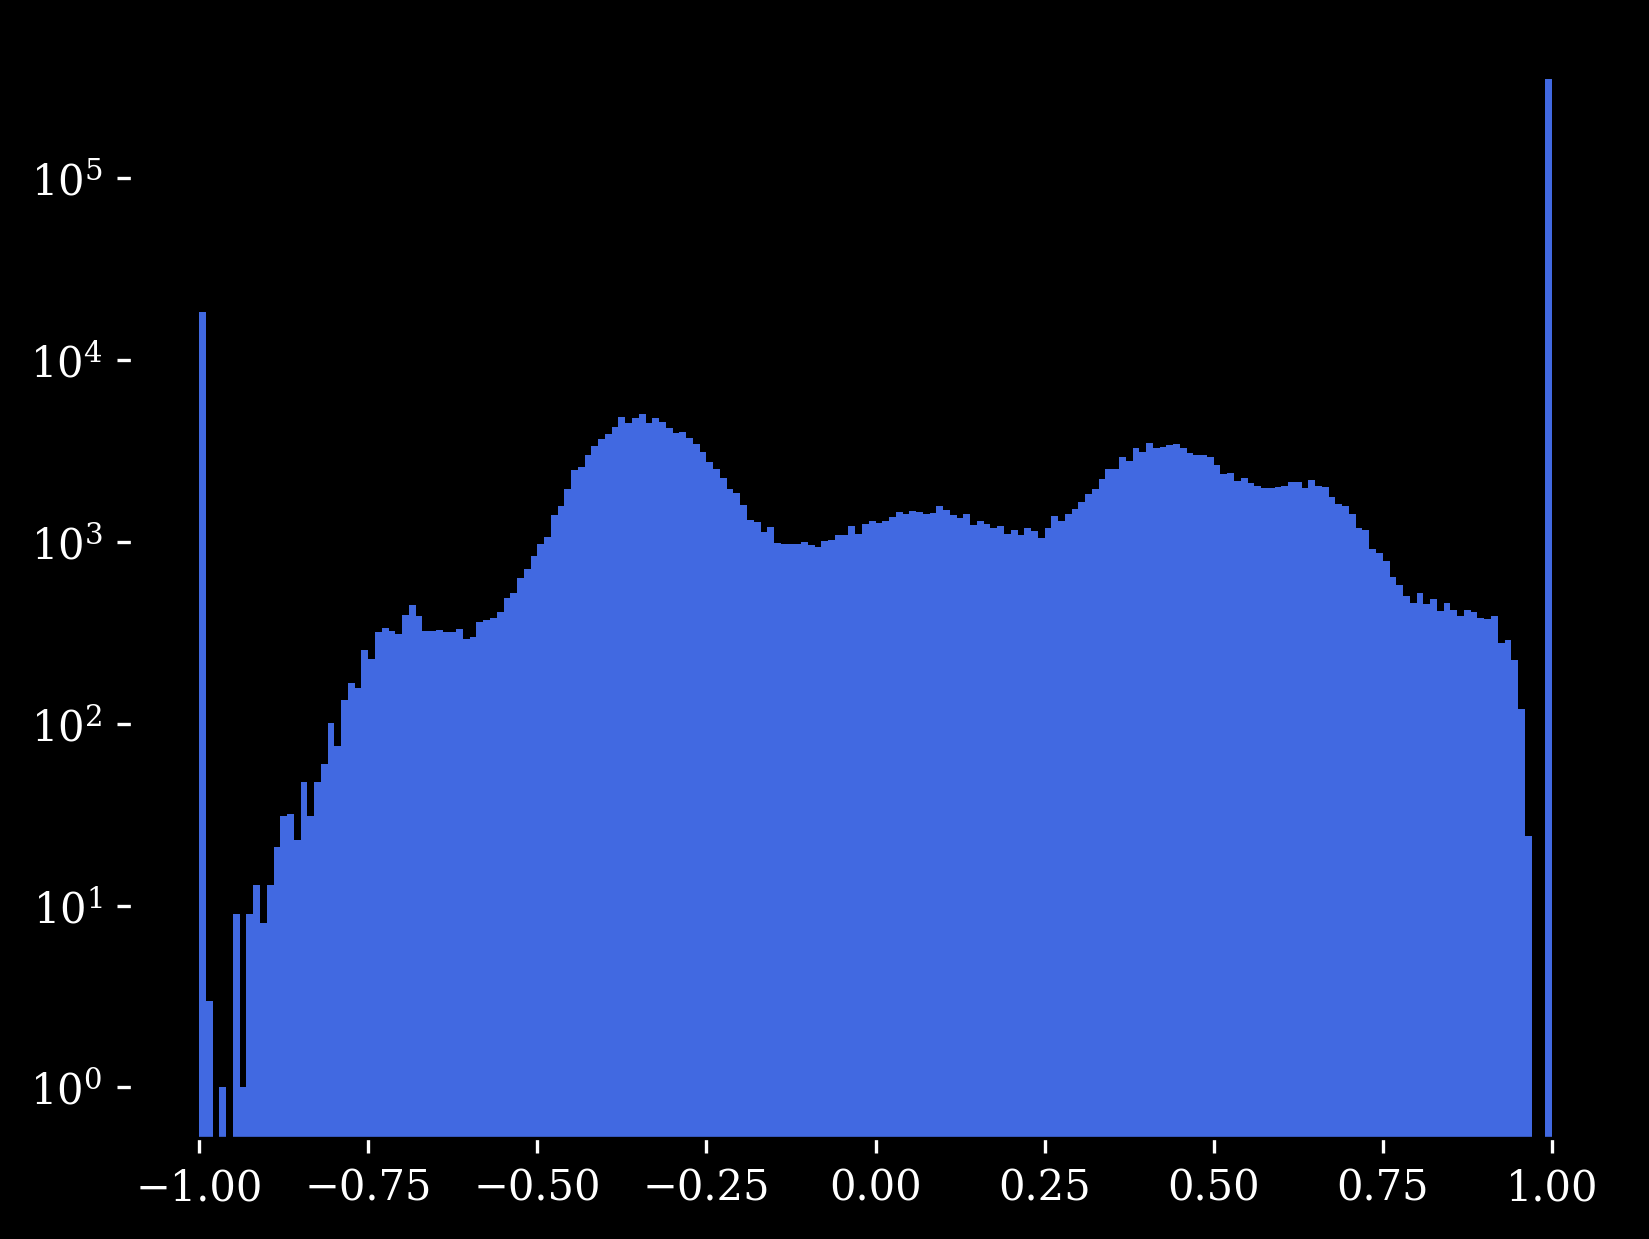

In [5]:
from scipy.signal import argrelextrema


RY = intensity_all[(intensity_all['R/A'] == 0)&(intensity_all['G/A'] >= 0.2)] 
order = 5
extension = 0

fig, ax = plt.subplots(facecolor='black')
hist = ax.hist(pd.DataFrame(RY['B/A'] - RY['Ye/A']), bins=200, 
               color='royalblue', log=True)
ax.set_facecolor('black')
ax.tick_params(colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.title.set_color('white')

freq, bins = hist[0], hist[1]
extrema_less = argrelextrema(freq, np.less, order=order)[0]
print(extrema_less)
bins_less = [(bins[extrema_less[i]+1] + extension, bins[extrema_less[i]] - extension) for i in range(len(extrema_less) - 1)]
bins_less.append((bins[-2], bins[-1]))
print(bins_less)

plt.savefig('BY_HH_PRISM.jpg')

plt.show()

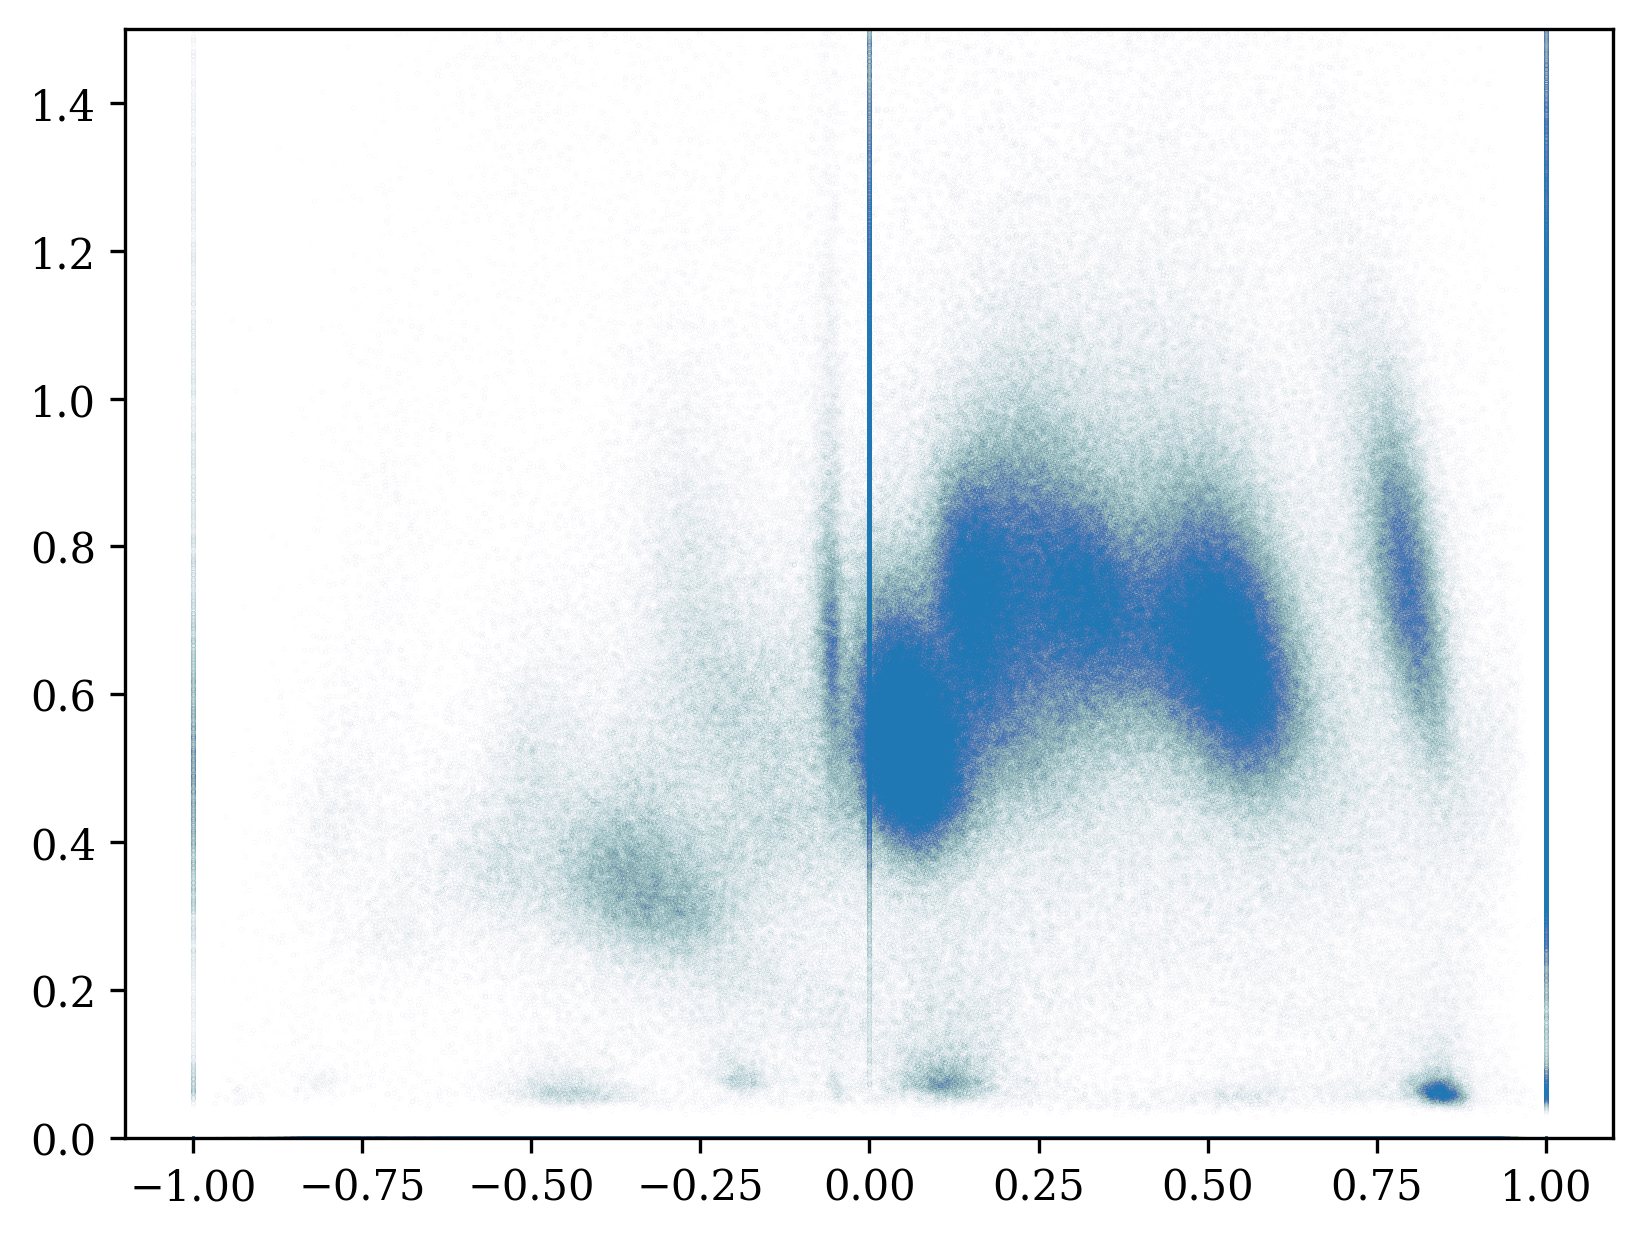

In [6]:
plt.scatter(intensity_all['Y_coor'],intensity_all['G/A'],s=0.0003,alpha=0.08,linewidths=None)
plt.ylim([0,1.5])
plt.savefig(read_dir/'0G_1G.jpg')

In [7]:
intensity_low = intensity_all[intensity_all['G/A']<=0.1]
intensity_high = intensity_all[intensity_all['G/A']>=0.2]

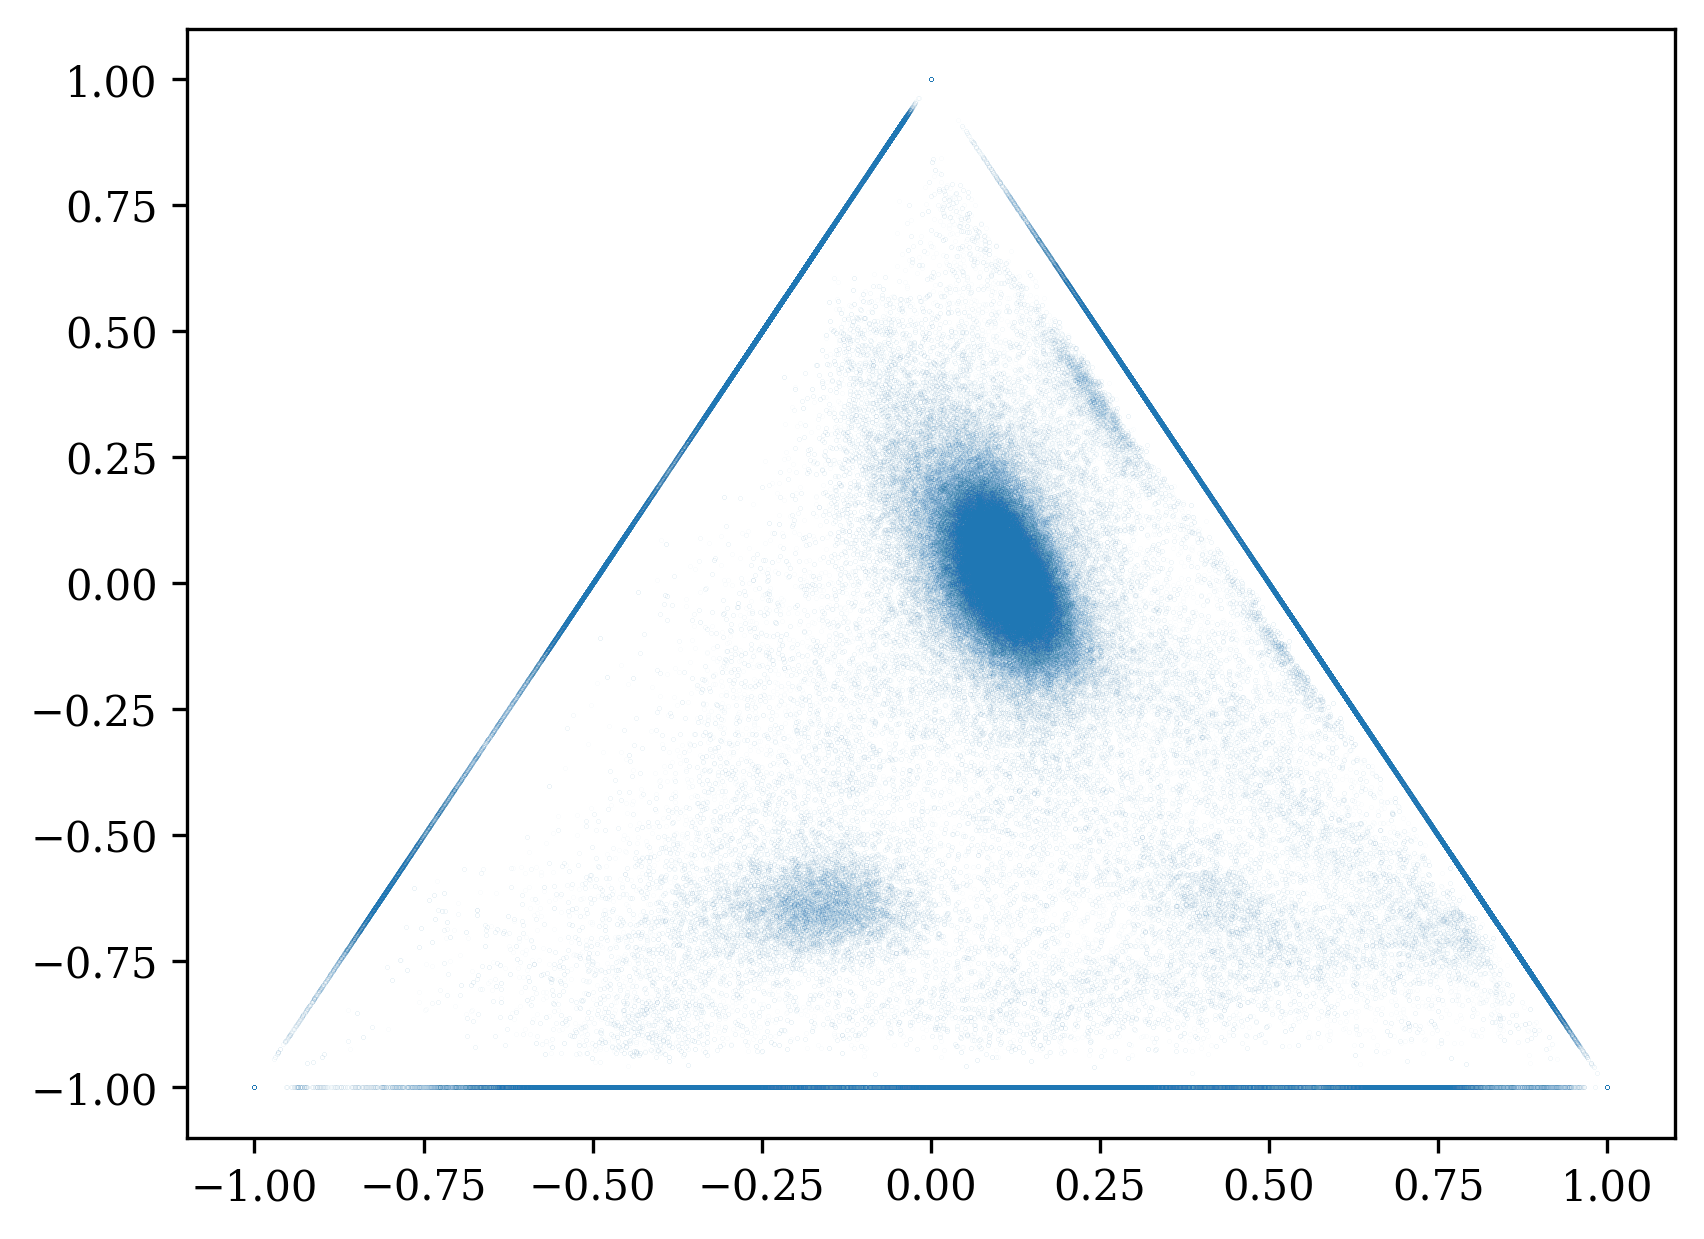

In [8]:
plt.scatter(intensity_low['Y_coor'],intensity_low['X_coor'],s=0.0009,alpha=0.15,linewidths=None)
plt.savefig(read_dir/'triangle_0G.jpg')

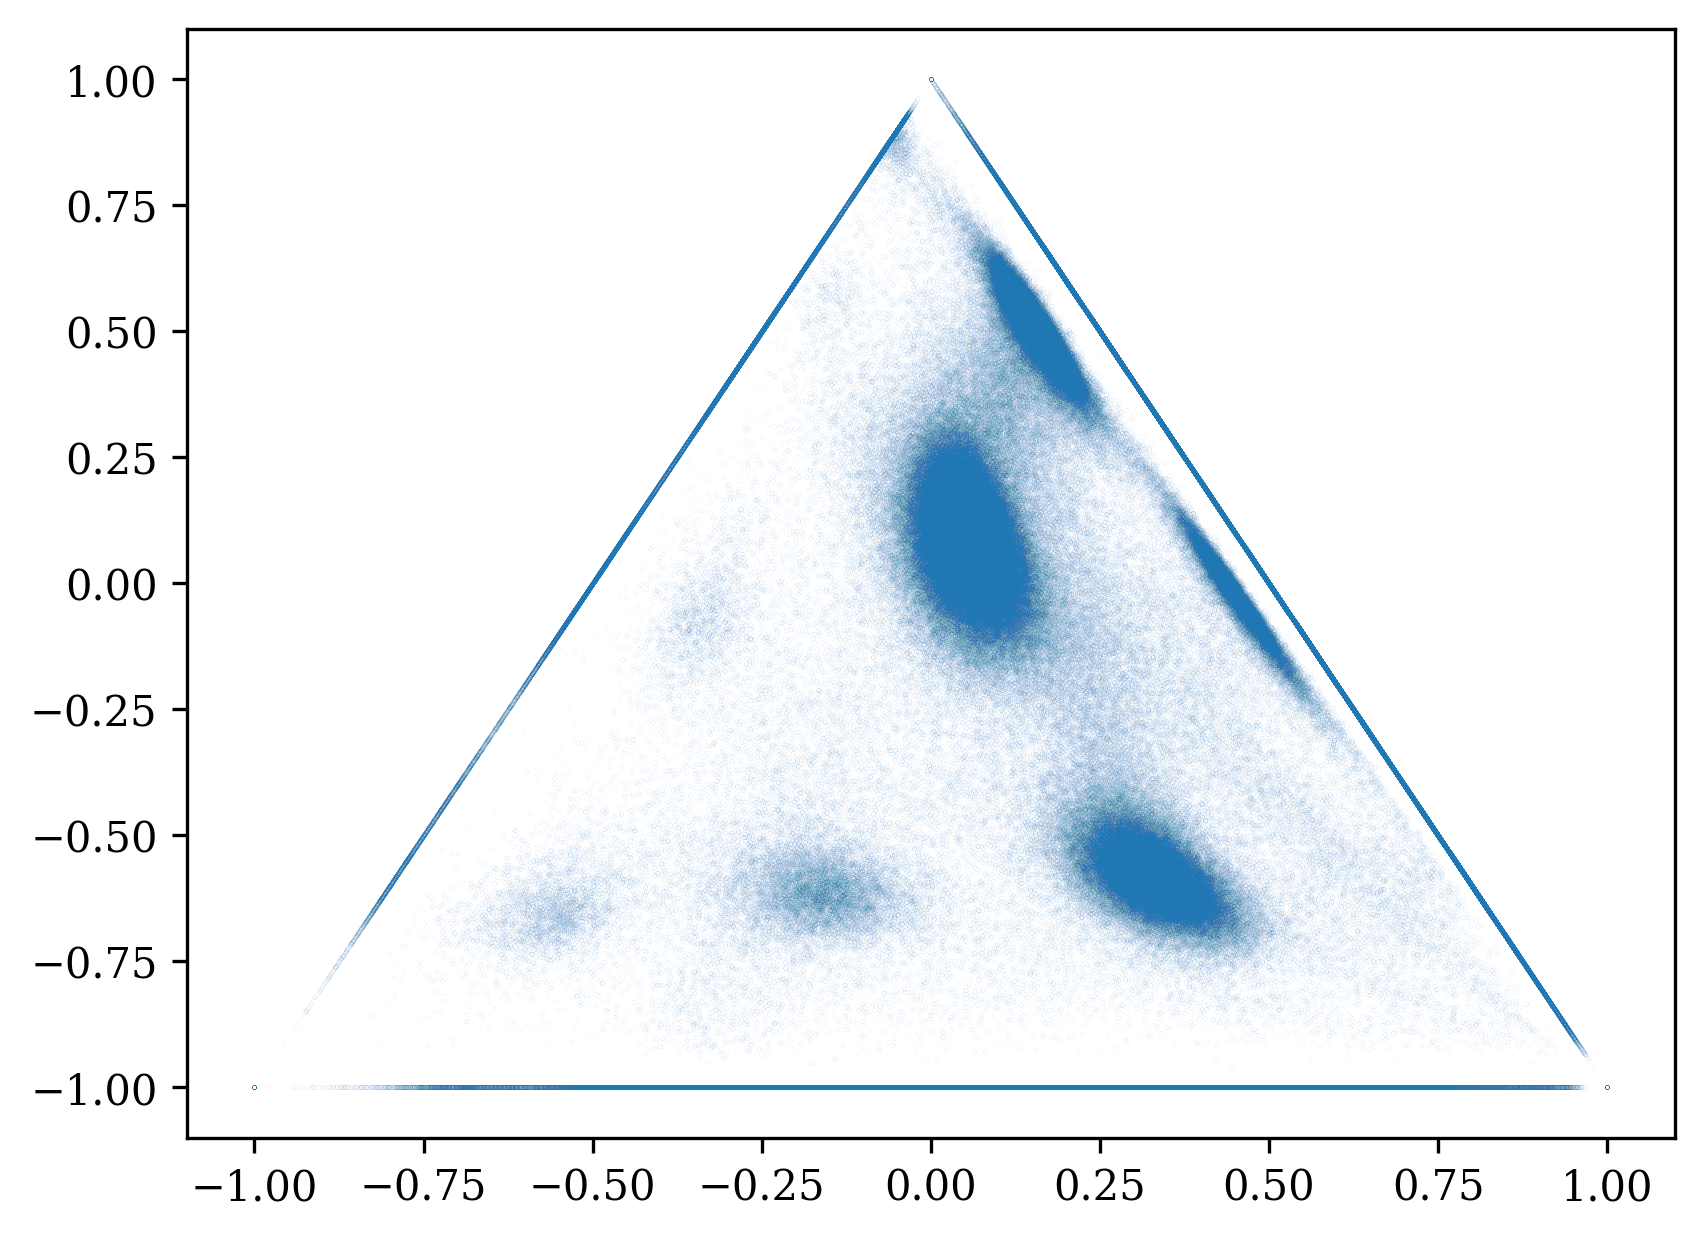

In [9]:
plt.scatter(intensity_high['Y_coor'],intensity_high['X_coor'],s=0.0009,alpha=0.08,linewidths=None)
plt.savefig(read_dir/'triangle_1G.jpg')

In [10]:
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema


def plot_freq(intensity, colorline, layer='1G', layer_threshold=0.25, order=5, contraction=0, vlines=True, curvefit_range=None, curvefit_p0=None,curvefit_pvalue=0.05, curvefit_colorset=['red', 'yellow', 'green'], save=False, read_dir=None):
    '''
    Plot a frequency plot.

    Parameters
    -----------
    intensity: pandas dataframe.
    colorline: projection line. 'RY', 'RB' or 'BY'.
    layer: the 4th color. '0G' or '1G'.
    layer_threshold: threshold of the 4th color. For '0G', it is the upper limit. For '1G', it is the lower limit.
    order: how many points on each side to use for the comparison to consider. For details, see scipy.signal.argrelextrema.
    contraction: distance between two peaks (= contraction*2). 
    vlines: whether to plot peak boundaries or not.
    curvefit_range: peak range to fit curve.
    curvefit_p0: initial guess for the parameters (length N). For details, see scipy.optimize.curve_fit.
    save: whether to save the plot alone.
    read_dir: 
    '''
    
    def gaussian(x, mu, sigma, A):
        return A*np.exp(-(x-mu)**2/(2*(sigma**2)))

    def mixgaussian(x, mu1, mu2, mu3, sigma1, sigma2, sigma3, A1, A2, A3):
        return gaussian(x, mu1, sigma1, A1) + gaussian(x, mu2, sigma2, A2) + gaussian(x, mu3, sigma3, A3)

    if layer == '0G':
        intensity = intensity[intensity['G/A'] <= layer_threshold]
    elif layer == '1G':
        intensity = intensity[intensity['G/A'] >= layer_threshold]

    if colorline == 'RY':
        intensity = intensity[intensity['B/A'] == 0] 
        intensity = intensity['R/A'] - intensity['Ye/A']
    elif colorline == 'RB':
        intensity = intensity[intensity['Ye/A'] == 0]
        intensity = intensity['R/A'] - intensity['B/A']
    elif colorline == 'BY':
        intensity = intensity[intensity['R/A'] == 0]
        intensity = intensity['B/A'] - intensity['Ye/A']

    hist = plt.hist(pd.DataFrame(intensity), bins = 200, log=True)
    freq, bins = hist[0], hist[1]
    extrema_less = argrelextrema(freq, np.less, order=order)[0] # assuming two side have 0, execute this code, or skip it
    bins_less = [(bins[extrema_less[i-1]+1]+contraction, bins[extrema_less[i]]-contraction) if i>0 else (bins[0], bins[1]) for i in range(len(extrema_less))]
    bins_less.append((bins[-2], bins[-1]))
    print('Peaks range of', colorline, bins_less)

    if vlines:
        plt.vlines([i[0] for i in bins_less], 0, 10000, linestyles='dashed', colors='red')
        plt.vlines([i[1] for i in bins_less], 0, 10000, linestyles='dashed', colors='green')

    if curvefit_range:
        confidence = 1 - curvefit_pvalue
        if confidence == 0.9: z = 1.28
        elif confidence == 0.95: z = 1.64

        start_idx, end_idx = curvefit_range[0], curvefit_range[1]
        bins_ = (bins[1:] + bins[:-1])/2 # for len(bins_) == len(freq)
        popt, pcov = curve_fit(mixgaussian, bins_[start_idx:end_idx], freq[start_idx:end_idx], p0=curvefit_p0, maxfev=1000000)

        # plot fitting curve separately: curve 1, curve 2, curve 3
        # curve 1
        mu, sigma, A = popt[0], popt[3], popt[6]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[0])
        print('Gaussian Curve 1: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])
        # curve 2
        mu, sigma, A = popt[1], popt[4], popt[7]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[1])
        print('Gaussian Curve 2: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])
        # curve 3
        mu, sigma, A = popt[2], popt[5], popt[8]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[2])
        print('Gaussian Curve 3: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])

    if save:
        if read_dir: plt.savefig(read_dir / (colorline+'_'+layer+'.jpg'))
        else: print('Input a read_dir to save the plot.\n') # Maybe a warning or error

Peaks range of RY [(-1.0, -0.99), (-0.30999999999999994, 0.21999999999999997), (0.22999999999999998, 0.79), (0.99, 1.0)]
Peaks range of RB [(-1.0, -0.99), (-0.98, -0.41000000000000003), (-0.4, 0.1100000000000001), (0.99, 1.0)]
Peaks range of BY [(-1.0, -0.99), (-0.08999999999999997, 0.5700000000000001), (0.5800000000000001, 0.8700000000000001), (0.8800000000000001, 0.97), (0.99, 1.0)]


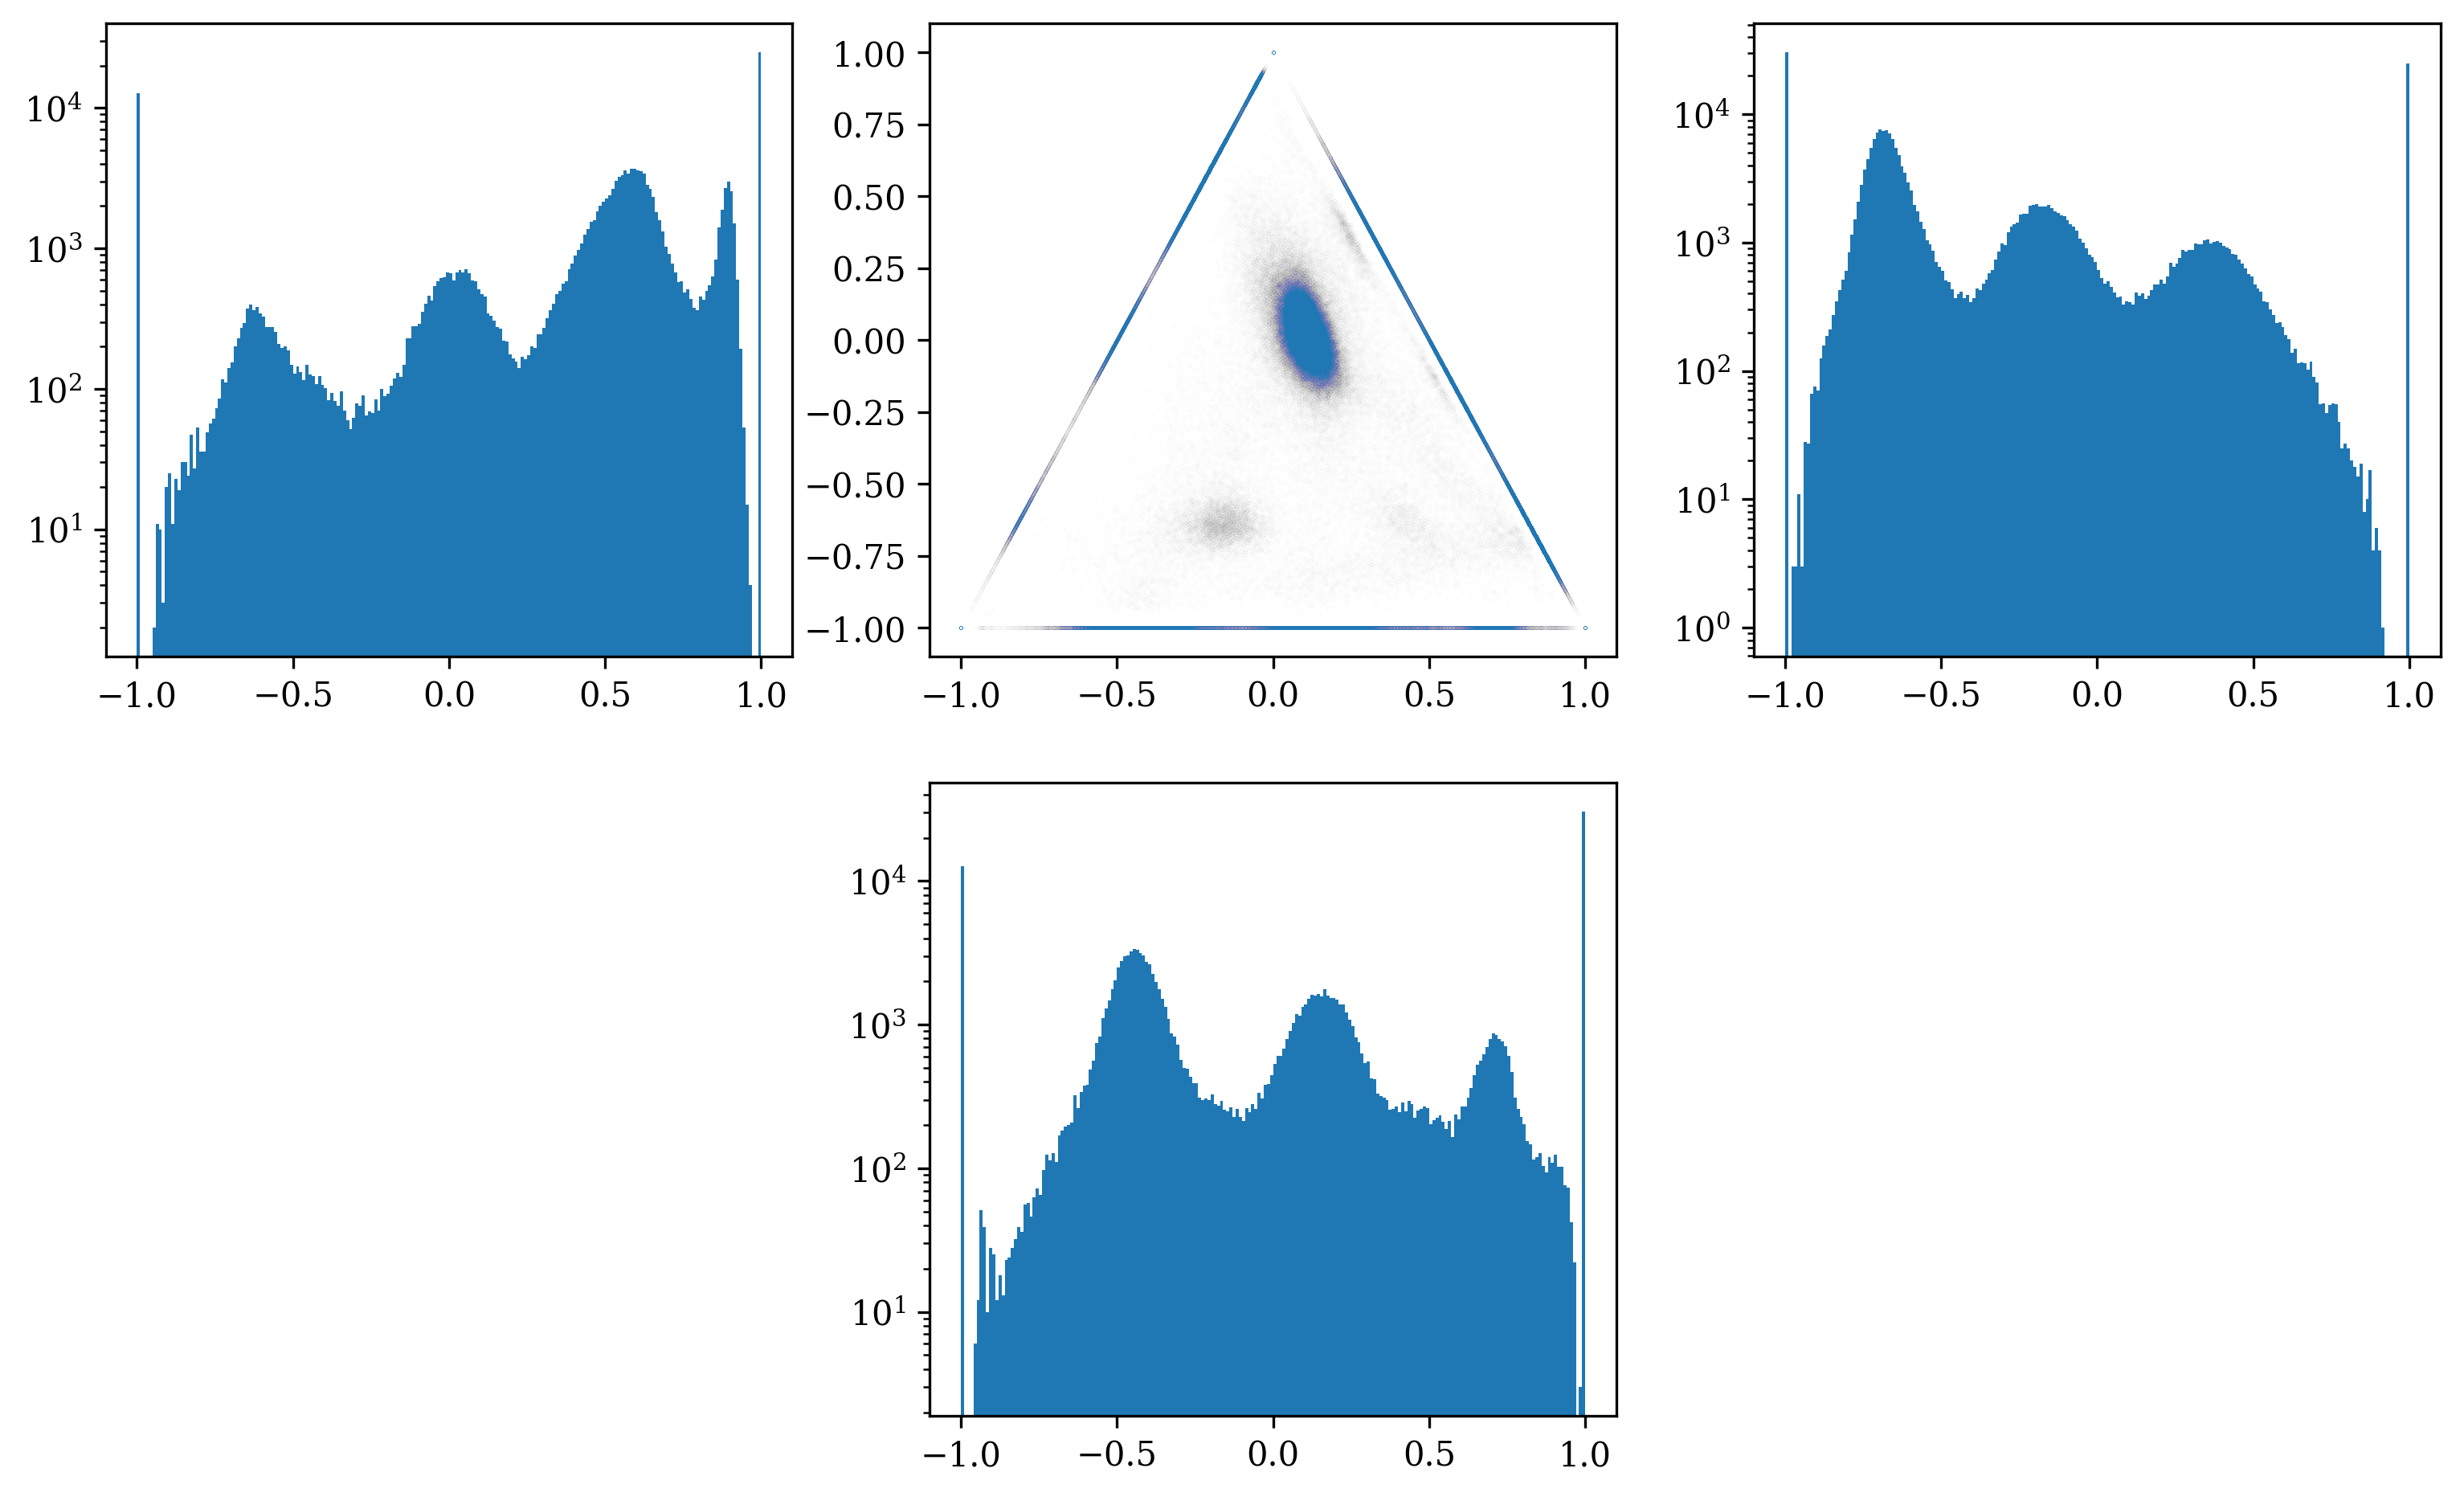

In [11]:
# plots: scatter + frequency plot in three dimension
fig = plt.figure()    # 生成新的画布fig
fig.set_size_inches(12.5, 7.5)     # 调整画布为合适大小

p0 = [-1, 1, 1, 1, 3, 3]
plt.subplot(232)  # scatter
plt.scatter(intensity_low['Y_coor'], intensity_low['X_coor'], s=0.00009, alpha=0.08, linewidths=None)
plt.subplot(231)   # red-yellow
plot_freq(intensity_all, colorline='RY', layer='0G', layer_threshold=0.1, vlines=False,curvefit_pvalue=0.05)#, curvefit_range=(10,190), curvefit_p0=(-0.5, 0, 0.5, 0.1, 0.1, 0.1, 1500, 500, 22000),curvefit_colorset=['gold', 'darkorange', 'orangered'])#, save=True, read_dir=src_dir / 'readout')
plt.subplot(233)   # red-blue
plot_freq(intensity_all, colorline='RB', layer='0G', layer_threshold=0.1, vlines=False,curvefit_pvalue=0.1)#, curvefit_range=(10,190), curvefit_p0=(-0.7, -0.25, 0.35, 0.1, 0.1, 0.1, 5000, 5000, 5000),curvefit_colorset=['darkviolet', 'magenta', 'deeppink'])#, save=True, read_dir=src_dir / 'readout')
plt.subplot(235)   # yellow-blue
plot_freq(intensity_all, colorline='BY', layer='0G', layer_threshold=0.1, vlines=False,curvefit_pvalue=0.1, save=True, read_dir=src_dir / 'readout')#, curvefit_range=(20,190), curvefit_p0=(-0.4, 0.2, 0.6, 0.1, 0.1, 0.1, 3000, 10000, 20000),curvefit_colorset=['greenyellow', 'springgreen', 'deepskyblue'], save=True, read_dir=src_dir / 'readout')

plt.show()

Peaks range of RY [(-1.0, -0.99), (-0.5700000000000001, -0.29999999999999993), (-0.29000000000000004, 0.18999999999999995), (0.19999999999999996, 0.74), (0.99, 1.0)]
Peaks range of RB [(-1.0, -0.99), (-0.33999999999999997, 0.28), (0.29000000000000004, 0.98), (0.99, 1.0)]
Peaks range of BY [(-1.0, -0.99), (-0.6, -0.08999999999999997), (-0.07999999999999996, 0.24), (0.25, 0.5800000000000001), (0.99, 1.0)]


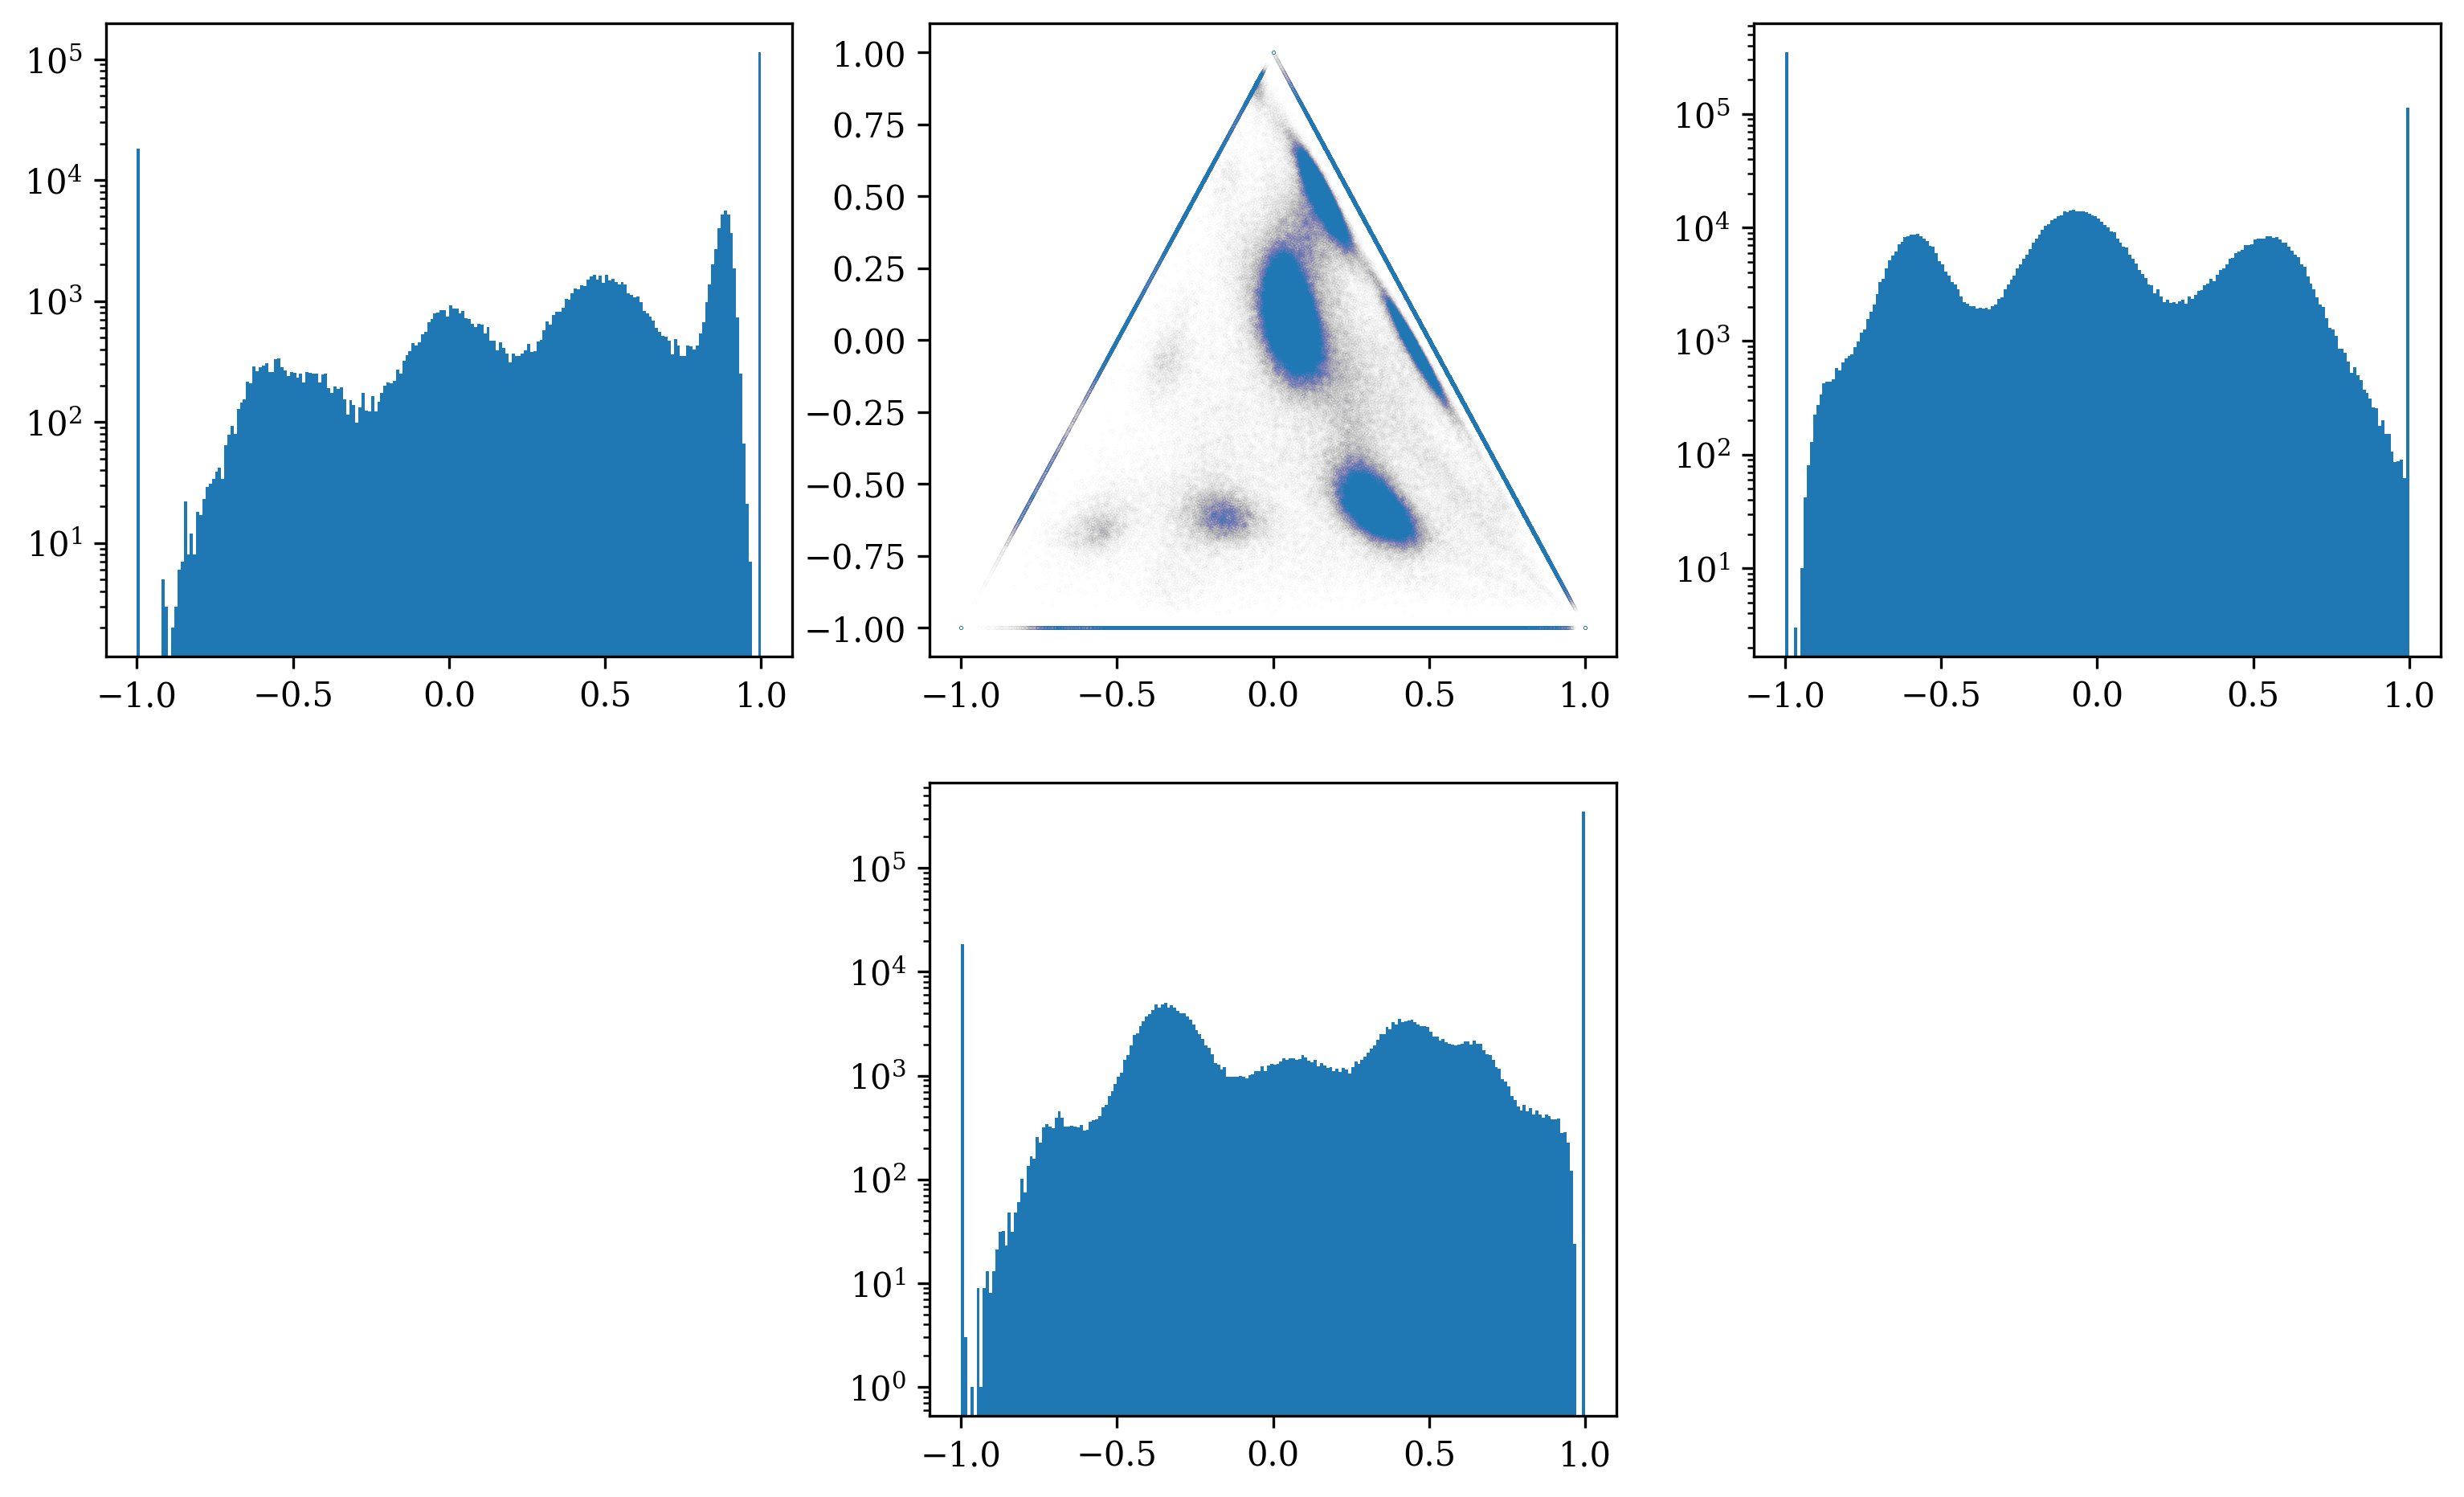

In [12]:
# plots: scatter + frequency plot in three dimension
fig = plt.figure()    # 生成新的画布fig
fig.set_size_inches(12.5, 7.5)     # 调整画布为合适大小

p0 = [-1, 1, 1, 1, 3, 3]
plt.subplot(232)  # scatter
plt.scatter(intensity_high['Y_coor'], intensity_high['X_coor'], s=0.00009, alpha=0.08, linewidths=None)
plt.subplot(231)   # red-yellow
plot_freq(intensity_all, colorline='RY', layer='1G', layer_threshold=0.2, vlines=False)#, curvefit_range=(10,160), curvefit_p0=(-0.55, -0.05, 0.45, 0.1, 0.1, 0.1, 1000, 1000, 6000),curvefit_colorset=['gold', 'darkorange', 'orangered'])#, save=True, read_dir=src_dir / 'readout')
plt.subplot(233)   # red-blue
plot_freq(intensity_all, colorline='RB', layer='1G', layer_threshold=0.2, vlines=False)#, curvefit_range=(10,160), curvefit_p0=(-0.6, -0.25, 0.35, 0.1, 0.1, 0.1, 5000, 5000, 5000),curvefit_colorset=['darkviolet', 'magenta', 'deeppink'])#, save=True, read_dir=src_dir / 'readout')
plt.subplot(235)   # yellow-blue
plot_freq(intensity_all, colorline='BY', layer='1G', layer_threshold=0.2, vlines=False, save=True, read_dir=src_dir / 'readout')#, curvefit_range=(20,190), curvefit_p0=(-0.4, 0.2, 0.6, 0.1, 0.1, 0.1, 3000, 10000, 20000),curvefit_colorset=['greenyellow', 'springgreen', 'deepskyblue'], save=True, read_dir=src_dir / 'readout')

plt.show()

## manual classification

### threshold by tissue

Here, we adjusted different threshold values for different samples for better gene calling effects. Choose appropriate set for specific data.

In [13]:
# HCC

G_Low_Thre = 0.12
G_High_Thre = 0.25

PRISM_1_XL = 0.83

PRISM_2_XL = 0.24
PRISM_2_XH = 0.79

PRISM_3_XL = -0.32
PRISM_3_XH = 0.22

PRISM_4_XL = -0.83
PRISM_4_XH = -0.33

PRISM_5_XH = -0.99

PRISM_6_XL = -0.88
PRISM_6_XH = -0.1

PRISM_7_XL = -0.09
PRISM_7_XH = 0.4

PRISM_8_XL = 0.5
PRISM_8_XH = 0.87

PRISM_9_XL = 0.99

PRISM_10_XL = -0.92
PRISM_10_XH = -0.46

PRISM_11_XL = -0.45
PRISM_11_XH = 0.1

PRISM_12_XL = 0.11
PRISM_12_XH = 0.65 #

PRISM_13_XL = -0.25
PRISM_13_XH = 0.23
PRISM_13_YL = 0
PRISM_13_YH = 0.24

PRISM_14_XL = -0.75
PRISM_14_XH = -0.5
PRISM_14_YL = -0.35
PRISM_14_YH = 0

PRISM_15_XL = -0.75
PRISM_15_XH = -0.5
PRISM_15_YL = 0.3
PRISM_15_YH = 0.55

PRISM_16_XL = 0.78 # 0.78

PRISM_17_XL = 0.25
PRISM_17_XH = 0.65

PRISM_18_XL = -0.29
PRISM_18_XH = 0.2 #

PRISM_19_XL = -0.75
PRISM_19_XH = -0.3

PRISM_20_XH = -0.65 #contract!

PRISM_21_XL = -0.55
PRISM_21_XH = -0.15

PRISM_22_XL = -0.05
PRISM_22_XH = 0.2

PRISM_23_XL = 0.25
PRISM_23_XH = 0.6

PRISM_24_XL = 0.99

PRISM_25_XL = -0.8 #
PRISM_25_XH = -0.45

PRISM_26_XL = -0.4
PRISM_26_XH = 0.28

PRISM_27_XL = 0.32
PRISM_27_XH = 0.75 #

PRISM_28_XL = -0.25
PRISM_28_XH = 0.22
PRISM_28_YL = -0.1
PRISM_28_YH = 0.18

PRISM_29_XL = -0.75
PRISM_29_XH = -0.5
PRISM_29_YL = -0.35
PRISM_29_YH = 0

PRISM_30_XL = -0.75
PRISM_30_XH = -0.45
PRISM_30_YL = 0.2
PRISM_30_YH = 0.55

PRISM_2_XL_Range = 0.9*PRISM_2_XL+0.1*PRISM_2_XH
PRISM_2_XH_Range = 0.1*PRISM_2_XL+0.9*PRISM_2_XH
PRISM_3_XL_Range = 0.9*PRISM_3_XL+0.1*PRISM_3_XH
PRISM_3_XH_Range = 0.1*PRISM_3_XL+0.9*PRISM_3_XH
PRISM_4_XL_Range = 0.9*PRISM_4_XL+0.1*PRISM_4_XH
PRISM_4_XH_Range = 0.1*PRISM_4_XL+0.9*PRISM_4_XH
PRISM_6_XL_Range = 0.9*PRISM_6_XL+0.1*PRISM_6_XH
PRISM_6_XH_Range = 0.1*PRISM_6_XL+0.9*PRISM_6_XH
PRISM_7_XL_Range = 0.9*PRISM_7_XL+0.1*PRISM_7_XH
PRISM_7_XH_Range = 0.1*PRISM_7_XL+0.9*PRISM_7_XH
PRISM_8_XL_Range = 0.9*PRISM_8_XL+0.1*PRISM_8_XH
PRISM_8_XH_Range = 0.1*PRISM_8_XL+0.9*PRISM_8_XH
PRISM_10_XL_Range = 0.9*PRISM_10_XL+0.1*PRISM_10_XH
PRISM_10_XH_Range = 0.1*PRISM_10_XL+0.9*PRISM_10_XH
PRISM_11_XL_Range = 0.9*PRISM_11_XL+0.1*PRISM_11_XH
PRISM_11_XH_Range = 0.1*PRISM_11_XL+0.9*PRISM_11_XH
PRISM_12_XL_Range = 0.9*PRISM_12_XL+0.1*PRISM_12_XH
PRISM_12_XH_Range = 0.1*PRISM_12_XL+0.9*PRISM_12_XH

PRISM_17_XL_Range = 0.9*PRISM_17_XL+0.1*PRISM_17_XH
PRISM_17_XH_Range = 0.1*PRISM_17_XL+0.9*PRISM_17_XH
PRISM_18_XL_Range = 0.9*PRISM_18_XL+0.1*PRISM_18_XH
PRISM_18_XH_Range = 0.1*PRISM_18_XL+0.9*PRISM_18_XH
PRISM_19_XL_Range = 0.9*PRISM_19_XL+0.1*PRISM_19_XH
PRISM_19_XH_Range = 0.1*PRISM_19_XL+0.9*PRISM_19_XH
PRISM_21_XL_Range = 0.9*PRISM_21_XL+0.1*PRISM_21_XH
PRISM_21_XH_Range = 0.1*PRISM_21_XL+0.9*PRISM_21_XH
PRISM_22_XL_Range = 0.9*PRISM_22_XL+0.1*PRISM_22_XH
PRISM_22_XH_Range = 0.1*PRISM_22_XL+0.9*PRISM_22_XH
PRISM_23_XL_Range = 0.9*PRISM_23_XL+0.1*PRISM_23_XH
PRISM_23_XH_Range = 0.1*PRISM_23_XL+0.9*PRISM_23_XH
PRISM_25_XL_Range = 0.9*PRISM_25_XL+0.1*PRISM_25_XH
PRISM_25_XH_Range = 0.1*PRISM_25_XL+0.9*PRISM_25_XH
PRISM_26_XL_Range = 0.9*PRISM_26_XL+0.1*PRISM_26_XH
PRISM_26_XH_Range = 0.1*PRISM_26_XL+0.9*PRISM_26_XH
PRISM_27_XL_Range = 0.9*PRISM_27_XL+0.1*PRISM_27_XH
PRISM_27_XH_Range = 0.1*PRISM_27_XL+0.9*PRISM_27_XH

intensity_all['Gene'] = 'Other'
intensity_all.loc[(intensity_all.X_coor >= PRISM_1_XL)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_1'
intensity_all.loc[(intensity_all.X_coor >= PRISM_2_XL_Range)&(intensity_all.X_coor <= PRISM_2_XH_Range)&(intensity_all.Y_coor >= (PRISM_2_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_2_XH_Range-1)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_2'
intensity_all.loc[(intensity_all.X_coor >= PRISM_3_XL_Range)&(intensity_all.X_coor <= PRISM_3_XH_Range)&(intensity_all.Y_coor >= (PRISM_3_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_3_XH_Range-1)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_3'
intensity_all.loc[(intensity_all.X_coor >= PRISM_4_XL_Range)&(intensity_all.X_coor <= PRISM_4_XH_Range)&(intensity_all.Y_coor >= (PRISM_4_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_4_XH_Range-1)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_4'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= PRISM_5_XH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_5'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_6_XL_Range)&(intensity_all.Y_coor <= PRISM_6_XH_Range)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_6'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_7_XL_Range)&(intensity_all.Y_coor <= PRISM_7_XH_Range)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_7'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_8_XL_Range)&(intensity_all.Y_coor <= PRISM_8_XH_Range)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_8'
intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= PRISM_9_XL)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_9'
intensity_all.loc[(intensity_all.X_coor >= PRISM_10_XL_Range)&(intensity_all.X_coor <= PRISM_10_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_10_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_10_XL_Range)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_10'
intensity_all.loc[(intensity_all.X_coor >= PRISM_11_XL_Range)&(intensity_all.X_coor <= PRISM_11_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_11_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_11_XL_Range)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_11'
intensity_all.loc[(intensity_all.X_coor >= PRISM_12_XL_Range)&(intensity_all.X_coor <= PRISM_12_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_12_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_12_XL_Range)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_12'
intensity_all.loc[(intensity_all.X_coor >= PRISM_13_XL)&(intensity_all.X_coor <= PRISM_13_XH)&(intensity_all.Y_coor >= PRISM_13_YL)&(intensity_all.Y_coor <= PRISM_13_YH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_13'
intensity_all.loc[(intensity_all.X_coor >= PRISM_14_XL)&(intensity_all.X_coor <= PRISM_14_XH)&(intensity_all.Y_coor >= PRISM_14_YL)&(intensity_all.Y_coor <= PRISM_14_YH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_14'
intensity_all.loc[(intensity_all.X_coor >= PRISM_15_XL)&(intensity_all.X_coor <= PRISM_15_XH)&(intensity_all.Y_coor >= PRISM_15_YL)&(intensity_all.Y_coor <= PRISM_15_YH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_15'

intensity_all.loc[(intensity_all.X_coor >= PRISM_16_XL)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_16'
intensity_all.loc[(intensity_all.X_coor >= PRISM_17_XL_Range)&(intensity_all.X_coor <= PRISM_17_XH)&(intensity_all.Y_coor >= (PRISM_17_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_17_XH_Range-1)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_17'
intensity_all.loc[(intensity_all.X_coor >= PRISM_18_XL_Range)&(intensity_all.X_coor <= PRISM_18_XH_Range)&(intensity_all.Y_coor >= (PRISM_18_XL_Range-1)/2)&(intensity_all.Y_coor <= -0.3)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_18'
intensity_all.loc[(intensity_all.X_coor >= PRISM_19_XL_Range)&(intensity_all.X_coor <= PRISM_19_XH_Range)&(intensity_all.Y_coor >=  (PRISM_19_XL_Range-1)/2)&(intensity_all.Y_coor <= -0.5)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_19'

intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= PRISM_20_XH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_20'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_21_XL_Range)&(intensity_all.Y_coor <= PRISM_21_XH_Range)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_21'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_22_XL_Range)&(intensity_all.Y_coor <= PRISM_22_XH_Range)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_22'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_23_XL_Range)&(intensity_all.Y_coor <= PRISM_23_XH_Range)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_23'
intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= PRISM_24_XL)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_24'
intensity_all.loc[(intensity_all.X_coor >= PRISM_25_XL_Range)&(intensity_all.X_coor <= PRISM_25_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_25_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_25_XL_Range)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_25'
intensity_all.loc[(intensity_all.X_coor >= PRISM_26_XL_Range)&(intensity_all.X_coor <= PRISM_26_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_26_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_26_XL_Range)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_26'
intensity_all.loc[(intensity_all.X_coor >= PRISM_27_XL_Range)&(intensity_all.X_coor <= PRISM_27_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_27_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_27_XL_Range)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_27'
intensity_all.loc[(intensity_all.X_coor >= PRISM_28_XL)&(intensity_all.X_coor <= PRISM_28_XH)&(intensity_all.Y_coor >= PRISM_28_YL)&(intensity_all.Y_coor <= PRISM_28_YH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_28'
intensity_all.loc[(intensity_all.X_coor >= PRISM_29_XL)&(intensity_all.X_coor <= PRISM_29_XH)&(intensity_all.Y_coor >= PRISM_29_YL)&(intensity_all.Y_coor <= PRISM_29_YH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_29'
intensity_all.loc[(intensity_all.X_coor >= PRISM_30_XL)&(intensity_all.X_coor <= PRISM_30_XH)&(intensity_all.Y_coor >= PRISM_30_YL)&(intensity_all.Y_coor <= PRISM_30_YH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_30'
intensity_all.loc[(intensity_all['G/A'] >= 10),'Gene'] = 'PRISM_31'

In [14]:
# # for new 30 plex

# intensity_all['Gene'] = 'Other'
# intensity_all.loc[(intensity_all.X_coor >= 0.98)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_1'
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.3)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_2'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= -0.55)&(intensity_all.Y_coor <= -0.45)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_3'
# intensity_all.loc[(intensity_all.X_coor >= -0.8)&(intensity_all.X_coor <= -0.4)&(intensity_all.Y_coor >= -0.9)&(intensity_all.Y_coor <= -0.7)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_4'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.98)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_5'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.6)&(intensity_all.Y_coor <= -0.15)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_6'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.05)&(intensity_all.Y_coor <= 0.35)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_7'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.5)&(intensity_all.Y_coor <= 0.75)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_8'
# intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_9'
# intensity_all.loc[(intensity_all.X_coor <= -0.55)&(intensity_all.X_coor >= -0.85)&(intensity_all.Y_coor >= 0.775)&(intensity_all.Y_coor <= 0.925)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_10'
# intensity_all.loc[(intensity_all.X_coor <= 0)&(intensity_all.X_coor >= -0.4)&(intensity_all.Y_coor >= 0.5)&(intensity_all.Y_coor <= 0.7)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_11'
# intensity_all.loc[(intensity_all.X_coor <= 0.7)&(intensity_all.X_coor >= 0.1)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.45)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_12'
# intensity_all.loc[(intensity_all.X_coor <= 0.)&(intensity_all.X_coor >= -0.25)&(intensity_all.Y_coor >= 0)&(intensity_all.Y_coor <= 0.3)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_13'
# intensity_all.loc[(intensity_all.X_coor <= -0.5)&(intensity_all.X_coor >= -0.75)&(intensity_all.Y_coor >= -0.45)&(intensity_all.Y_coor <= -0.05)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_14'
# intensity_all.loc[(intensity_all.X_coor <= -0.5)&(intensity_all.X_coor >= -0.85)&(intensity_all.Y_coor >= 0.3)&(intensity_all.Y_coor <= 0.6)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_15'

# intensity_all.loc[(intensity_all.X_coor >= 0.95)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_16'
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= -0.325)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_17'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= -0.55)&(intensity_all.Y_coor <= -0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_18' # 0.25->0.45
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.4)&(intensity_all.Y_coor >= -0.875)&(intensity_all.Y_coor <= -0.7)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_19'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.65)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_20'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.55)&(intensity_all.Y_coor <= -0.2)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_21'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.05)&(intensity_all.Y_coor <= 0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_22'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.5)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_23'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_24'
# intensity_all.loc[(intensity_all.X_coor >= -0.85)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= 0.75)&(intensity_all.Y_coor <= 0.925)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_25'
# intensity_all.loc[(intensity_all.X_coor >= -0.35)&(intensity_all.X_coor <= 0.1)&(intensity_all.Y_coor >= 0.45)&(intensity_all.Y_coor <= 0.675)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_26'
# intensity_all.loc[(intensity_all.X_coor >= 0.5)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_27'
# intensity_all.loc[(intensity_all.X_coor <= 0.25)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= 0)&(intensity_all.Y_coor <= 0.1)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_28'
# intensity_all.loc[(intensity_all.X_coor >= -0.7)&(intensity_all.X_coor <= -0.45)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_29'
# intensity_all.loc[(intensity_all.X_coor >= -0.7)&(intensity_all.X_coor <= -0.45)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.45)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_30'

In [15]:
# # for E 13.5
# intensity_all['Gene'] = 'Other'
# intensity_all.loc[(intensity_all.X_coor >= 0.999)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_1'
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.3)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_2'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.15)&(intensity_all.Y_coor >= -0.575)&(intensity_all.Y_coor <= -0.45)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_3'
# intensity_all.loc[(intensity_all.X_coor >= -0.8)&(intensity_all.X_coor <= -0.4)&(intensity_all.Y_coor >= -0.9)&(intensity_all.Y_coor <= -0.7)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_4'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.98)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_5'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.6)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_6'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.15)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_7'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_8'
# intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_9'
# intensity_all.loc[(intensity_all.X_coor <= -0.55)&(intensity_all.X_coor >= -0.85)&(intensity_all.Y_coor >= 0.775)&(intensity_all.Y_coor <= 0.925)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_10'
# intensity_all.loc[(intensity_all.X_coor <= -0.1)&(intensity_all.X_coor >= -0.4)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.7)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_11'
# intensity_all.loc[(intensity_all.X_coor <= 0.7)&(intensity_all.X_coor >= 0.1)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.45)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_12'
# intensity_all.loc[(intensity_all.X_coor <= 0)&(intensity_all.X_coor >= -0.25)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.3)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_13'
# intensity_all.loc[(intensity_all.X_coor <= -0.5)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0.1)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_14'
# intensity_all.loc[(intensity_all.X_coor <= -0.6)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= 0.4)&(intensity_all.Y_coor <= 0.6)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_15'

# intensity_all.loc[(intensity_all.X_coor >= 0.8)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_16' #0.95_2_7
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.325)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_17'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= -0.55)&(intensity_all.Y_coor <= -0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_18'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.4)&(intensity_all.Y_coor >= -0.875)&(intensity_all.Y_coor <= -0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_19'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.6)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_20'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_21'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_22'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_23'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_24'
# intensity_all.loc[(intensity_all.X_coor >= -0.85)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= 0.75)&(intensity_all.Y_coor <= 0.925)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_25'
# intensity_all.loc[(intensity_all.X_coor >= -0.3)&(intensity_all.X_coor <= 0.1)&(intensity_all.Y_coor >= 0.45)&(intensity_all.Y_coor <= 0.65)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_26'
# intensity_all.loc[(intensity_all.X_coor >= 0.3)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_27'
# intensity_all.loc[(intensity_all.X_coor <= 0.2)&(intensity_all.X_coor >= -0.2)&(intensity_all.Y_coor >= -0.1)&(intensity_all.Y_coor <= 0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_28'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_29'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.35)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.5)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_30'

In [16]:
# # for E 13.5 1_16
# intensity_all['Gene'] = 'Other'
# intensity_all.loc[(intensity_all.X_coor >= 0.999)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_1'
# intensity_all.loc[(intensity_all.X_coor >= 0.2)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_2'
# intensity_all.loc[(intensity_all.X_coor <= -0.1)&(intensity_all.X_coor >= -0.35)&(intensity_all.Y_coor >= -0.675)&(intensity_all.Y_coor <= -0.55)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_3'
# intensity_all.loc[(intensity_all.X_coor >= -0.95)&(intensity_all.X_coor <= -0.6)&(intensity_all.Y_coor >= -0.975)&(intensity_all.Y_coor <= -0.8)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_4'
# intensity_all.loc[(intensity_all.X_coor <= -0.99)&(intensity_all.Y_coor <= -0.8)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_5'
# intensity_all.loc[(intensity_all.X_coor <= -0.99)&(intensity_all.Y_coor >= -0.5)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_6'
# intensity_all.loc[(intensity_all.X_coor <= -0.99)&(intensity_all.Y_coor >= 0.2)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_7'
# intensity_all.loc[(intensity_all.X_coor <= -0.99)&(intensity_all.Y_coor >= 0.6)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_8'
# intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_9'
# intensity_all.loc[(intensity_all.X_coor <= -0.75)&(intensity_all.X_coor >= -0.95)&(intensity_all.Y_coor >= 0.875)&(intensity_all.Y_coor <= 0.975)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_10'
# intensity_all.loc[(intensity_all.X_coor <= -0.3)&(intensity_all.X_coor >= -0.6)&(intensity_all.Y_coor >= 0.65)&(intensity_all.Y_coor <= 0.8)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_11'
# intensity_all.loc[(intensity_all.X_coor <= 0.5)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.55)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_12'
# intensity_all.loc[(intensity_all.X_coor <= -0.1)&(intensity_all.X_coor >= -0.5)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.35)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_13'
# intensity_all.loc[(intensity_all.X_coor <= -0.6)&(intensity_all.X_coor >= -0.85)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0.1)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_14'
# intensity_all.loc[(intensity_all.X_coor <= -0.7)&(intensity_all.X_coor >= -0.85)&(intensity_all.Y_coor >= 0.4)&(intensity_all.Y_coor <= 0.6)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_15'

# intensity_all.loc[(intensity_all.X_coor >= 0.95)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_16'
# intensity_all.loc[(intensity_all.X_coor >= 0.25)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.325)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_17'
# intensity_all.loc[(intensity_all.X_coor <= 0)&(intensity_all.X_coor >= -0.4)&(intensity_all.Y_coor >= -0.7)&(intensity_all.Y_coor <= -0.35)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_18'
# intensity_all.loc[(intensity_all.X_coor >= -0.9)&(intensity_all.X_coor <= -0.6)&(intensity_all.Y_coor >= -0.95)&(intensity_all.Y_coor <= -0.45)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_19'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.6)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_20'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_21'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_22'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_23'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_24'
# intensity_all.loc[(intensity_all.X_coor >= -0.95)&(intensity_all.X_coor <= -0.6)&(intensity_all.Y_coor >= 0.8)&(intensity_all.Y_coor <= 0.975)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_25'
# intensity_all.loc[(intensity_all.X_coor >= -0.55)&(intensity_all.X_coor <= 0)&(intensity_all.Y_coor >= 0.5)&(intensity_all.Y_coor <= 0.775)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_26'
# intensity_all.loc[(intensity_all.X_coor >= 0.1)&(intensity_all.X_coor <= 0.6)&(intensity_all.Y_coor >= 0.2)&(intensity_all.Y_coor <= 0.45)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_27'
# intensity_all.loc[(intensity_all.X_coor <= 0)&(intensity_all.X_coor >= -0.35)&(intensity_all.Y_coor >= 0)&(intensity_all.Y_coor <= 0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_28'
# intensity_all.loc[(intensity_all.X_coor >= -0.85)&(intensity_all.X_coor <= -0.65)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_29'
# intensity_all.loc[(intensity_all.X_coor >= -0.85)&(intensity_all.X_coor <= -0.6)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.55)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_30'

In [17]:
# # SPEPCIFIC FOR E11.5
# intensity_all['Gene'] = 'Other'
# intensity_all.loc[(intensity_all.X_coor >= 0.999)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_1'
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= -0.3)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_2'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.15)&(intensity_all.Y_coor >= -0.575)&(intensity_all.Y_coor <= -0.45)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_3'
# intensity_all.loc[(intensity_all.X_coor >= -0.8)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= -0.9)&(intensity_all.Y_coor <= -0.7)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_4'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.98)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_5'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.6)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_6'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.2)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_7'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_8'
# intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_9'
# intensity_all.loc[(intensity_all.X_coor <= -0.6)&(intensity_all.X_coor >= -0.9)&(intensity_all.Y_coor >= 0.8)&(intensity_all.Y_coor <= 0.95)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_10'
# intensity_all.loc[(intensity_all.X_coor <= -0.1)&(intensity_all.X_coor >= -0.4)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.7)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_11'
# intensity_all.loc[(intensity_all.X_coor <= 0.7)&(intensity_all.X_coor >= 0.1)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.45)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_12'
# intensity_all.loc[(intensity_all.X_coor <= 0)&(intensity_all.X_coor >= -0.25)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.3)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_13'
# intensity_all.loc[(intensity_all.X_coor <= -0.5)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0.1)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_14'
# intensity_all.loc[(intensity_all.X_coor <= -0.6)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= 0.4)&(intensity_all.Y_coor <= 0.6)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_15'

# intensity_all.loc[(intensity_all.X_coor >= 0.95)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_16'
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.325)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_17'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= -0.55)&(intensity_all.Y_coor <= -0.25)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_18'
# intensity_all.loc[(intensity_all.X_coor >= -0.8)&(intensity_all.X_coor <= -0.4)&(intensity_all.Y_coor >= -0.9)&(intensity_all.Y_coor <= -0.4)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_19'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.6)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_20'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_21'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_22'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_23'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_24'
# intensity_all.loc[(intensity_all.X_coor >= -0.9)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= 0.75)&(intensity_all.Y_coor <= 0.95)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_25'
# intensity_all.loc[(intensity_all.X_coor >= -0.25)&(intensity_all.X_coor <= 0.05)&(intensity_all.Y_coor >= 0.475)&(intensity_all.Y_coor <= 0.625)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_26'
# intensity_all.loc[(intensity_all.X_coor >= 0.3)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_27'
# intensity_all.loc[(intensity_all.X_coor <= 0.25)&(intensity_all.X_coor >= -0.25)&(intensity_all.Y_coor >= 0)&(intensity_all.Y_coor <= 0.25)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_28'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_29'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.5)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_30'

In [18]:
# # SPEPCIFIC FOR E12.5
# intensity_all['Gene'] = 'Other'
# intensity_all.loc[(intensity_all.X_coor >= 0.999)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_1'
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= -0.3)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_2'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.15)&(intensity_all.Y_coor >= -0.575)&(intensity_all.Y_coor <= -0.45)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_3'
# intensity_all.loc[(intensity_all.X_coor >= -0.8)&(intensity_all.X_coor <= -0.35)&(intensity_all.Y_coor >= -0.9)&(intensity_all.Y_coor <= -0.675)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_4'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.98)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_5'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.6)&(intensity_all.Y_coor <= -0.05)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_6'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.2)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_7'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_8'
# intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_9'
# intensity_all.loc[(intensity_all.X_coor <= -0.6)&(intensity_all.X_coor >= -0.9)&(intensity_all.Y_coor >= 0.8)&(intensity_all.Y_coor <= 0.95)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_10'
# intensity_all.loc[(intensity_all.X_coor <= -0.1)&(intensity_all.X_coor >= -0.4)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.7)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_11'
# intensity_all.loc[(intensity_all.X_coor <= 0.7)&(intensity_all.X_coor >= 0.1)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.45)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_12'
# intensity_all.loc[(intensity_all.X_coor <= 0)&(intensity_all.X_coor >= -0.25)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.3)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_13'
# intensity_all.loc[(intensity_all.X_coor <= -0.5)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0.1)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_14'
# intensity_all.loc[(intensity_all.X_coor <= -0.6)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= 0.4)&(intensity_all.Y_coor <= 0.6)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_15'

# intensity_all.loc[(intensity_all.X_coor >= 0.95)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_16'
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.325)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_17'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= -0.55)&(intensity_all.Y_coor <= -0.25)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_18'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.4)&(intensity_all.Y_coor >= -0.875)&(intensity_all.Y_coor <= -0.4)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_19'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.6)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_20'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_21'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_22'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_23'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_24'
# intensity_all.loc[(intensity_all.X_coor >= -0.85)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= 0.75)&(intensity_all.Y_coor <= 0.925)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_25'
# intensity_all.loc[(intensity_all.X_coor >= -0.25)&(intensity_all.X_coor <= 0.05)&(intensity_all.Y_coor >= 0.475)&(intensity_all.Y_coor <= 0.625)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_26'
# intensity_all.loc[(intensity_all.X_coor >= 0.3)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_27'
# intensity_all.loc[(intensity_all.X_coor <= 0.25)&(intensity_all.X_coor >= -0.25)&(intensity_all.Y_coor >= 0)&(intensity_all.Y_coor <= 0.25)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_28'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_29'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.5)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_30'

In [19]:
# # SPEPCIFIC FOR CA
# intensity_all['Gene'] = 'Other'
# intensity_all.loc[(intensity_all.X_coor >= 0.999)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_1'
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= -0.3)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_2'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.15)&(intensity_all.Y_coor >= -0.575)&(intensity_all.Y_coor <= -0.45)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_3'
# intensity_all.loc[(intensity_all.X_coor >= -0.8)&(intensity_all.X_coor <= -0.35)&(intensity_all.Y_coor >= -0.9)&(intensity_all.Y_coor <= -0.675)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_4'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.98)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_5'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.6)&(intensity_all.Y_coor <= -0.15)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_6'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_7'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_8'
# intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_9'
# intensity_all.loc[(intensity_all.X_coor <= -0.6)&(intensity_all.X_coor >= -0.9)&(intensity_all.Y_coor >= 0.8)&(intensity_all.Y_coor <= 0.95)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_10'
# intensity_all.loc[(intensity_all.X_coor <= 0)&(intensity_all.X_coor >= -0.4)&(intensity_all.Y_coor >= 0.5)&(intensity_all.Y_coor <= 0.7)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_11'
# intensity_all.loc[(intensity_all.X_coor <= 0.7)&(intensity_all.X_coor >= 0.1)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.45)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_12'
# intensity_all.loc[(intensity_all.X_coor <= 0)&(intensity_all.X_coor >= -0.25)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.3)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_13'
# intensity_all.loc[(intensity_all.X_coor <= -0.5)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0.1)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_14'
# intensity_all.loc[(intensity_all.X_coor <= -0.6)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= 0.4)&(intensity_all.Y_coor <= 0.6)&(intensity_all['G/A'] <= 0.15),'Gene'] = 'PRISM_15'

# intensity_all.loc[(intensity_all.X_coor >= 0.95)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_16'
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.7)&(intensity_all.Y_coor >= -0.325)&(intensity_all.Y_coor <= -0.15)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_17'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= -0.55)&(intensity_all.Y_coor <= -0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_18'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.4)&(intensity_all.Y_coor >= -0.875)&(intensity_all.Y_coor <= -0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_19'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.6)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_20'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_21'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_22'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.5)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_23'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_24'
# intensity_all.loc[(intensity_all.X_coor >= -0.85)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= 0.75)&(intensity_all.Y_coor <= 0.925)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_25'
# intensity_all.loc[(intensity_all.X_coor >= -0.25)&(intensity_all.X_coor <= 0.05)&(intensity_all.Y_coor >= 0.475)&(intensity_all.Y_coor <= 0.625)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_26'
# intensity_all.loc[(intensity_all.X_coor >= 0.3)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_27'
# intensity_all.loc[(intensity_all.X_coor <= 0.25)&(intensity_all.X_coor >= -0.25)&(intensity_all.Y_coor >= 0)&(intensity_all.Y_coor <= 0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_28'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_29'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.5)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_30'

In [20]:
# # for 20plex CeA

# intensity_all['Gene'] = 'Other'
# intensity_all.loc[(intensity_all.X_coor >= 0.8)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_1'
# intensity_all.loc[(intensity_all.X_coor >= 0.2)&(intensity_all.X_coor <= 0.6)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.2)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_2'
# intensity_all.loc[(intensity_all.X_coor <= -0.2)&(intensity_all.X_coor >= -0.6)&(intensity_all.Y_coor >= -0.8)&(intensity_all.Y_coor <= -0.6)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_3'
# intensity_all.loc[(intensity_all.X_coor <= -0.8)&(intensity_all.Y_coor <= -0.9)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_4'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.5)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_5'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.75)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_6'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.9)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_7'
# intensity_all.loc[(intensity_all.X_coor <= -0.5)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= 0.75)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_8'
# intensity_all.loc[(intensity_all.X_coor <= 0.4)&(intensity_all.X_coor >= -0.2)&(intensity_all.Y_coor >= 0.3)&(intensity_all.Y_coor <= 0.6)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_9'
# intensity_all.loc[(intensity_all.X_coor <= -0.3)&(intensity_all.X_coor >= -0.7)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.5)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_10'

# intensity_all.loc[(intensity_all.X_coor >= 0.8)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_11'
# intensity_all.loc[(intensity_all.X_coor >= 0)&(intensity_all.X_coor <= 0.6)&(intensity_all.Y_coor >= -0.5)&(intensity_all.Y_coor <= -0.2)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_12'
# intensity_all.loc[(intensity_all.X_coor <= -0.2)&(intensity_all.X_coor >= -0.6)&(intensity_all.Y_coor >= -0.8)&(intensity_all.Y_coor <= -0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_13'
# intensity_all.loc[(intensity_all.X_coor <= -0.8)&(intensity_all.Y_coor <= -0.6)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_14'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.3)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_15'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.2)&(intensity_all.Y_coor <= 0.8)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_16'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.9)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_17'
# intensity_all.loc[(intensity_all.X_coor <= -0.2)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= 0.6)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_18'
# intensity_all.loc[(intensity_all.X_coor <= 0.75)&(intensity_all.X_coor >= 0)&(intensity_all.Y_coor >= 0.125)&(intensity_all.Y_coor <= 0.5)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_19'
# intensity_all.loc[(intensity_all.X_coor <= -0.3)&(intensity_all.X_coor >= -0.7)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.35)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_20'

In [21]:
intensity_all = intensity_all.astype({'Y':int, 'X':int})
intensity_all[['Y','X','Gene']].to_csv(read_dir/'mapped_genes.csv')

## remove duplicates

In [22]:
from scipy.spatial import KDTree

def remove_duplicates(coordinates):
    tree = KDTree(coordinates)
    pairs = tree.query_pairs(2)
    #print(f'{len(pairs)} duplicates pairs')
    neighbors = {} #dictionary of neighbors
    for i,j in pairs: #iterate over all pairs
        if i not in neighbors:
            neighbors[i] = set([j])
        else:
            neighbors[i].add(j)
        if j not in neighbors:
            neighbors[j] = set([i])
        else:
            neighbors[j].add(i)
    #print(f'{len(neighbors)} neighbor entries')
    keep = []
    discard = set() # a list would work, but I use a set for fast member testing with `in`
    nodes = set([s[0] for s in pairs]+[s[1] for s in pairs])
    for node in nodes:
        if node not in discard: # if node already in discard set: skip
            keep.append(node) # add node to keep list
            discard.update(neighbors.get(node,set())) #add node's neighbors to discard set
    #print(f'{len(discard)} nodes discarded, {len(keep)} nodes kept')
    centroids_simplified = np.delete(coordinates, list(discard), axis=0)
    #print(f'{centroids_simplified.shape[0]} centroids after simplification')
    return centroids_simplified

In [23]:
df = intensity_all[['Y','X','Gene']]
df_reduced = pd.DataFrame()
for gene in tqdm(set(df['Gene'])):
    df_gene = df[df['Gene'] == gene]
    coordinates = df_gene[['Y','X']].values
    coordinates = remove_duplicates(coordinates)
    df_gene_reduced = pd.DataFrame(coordinates, columns=['Y','X'])
    df_gene_reduced['Gene'] = gene
    df_reduced = pd.concat([df_reduced,df_gene_reduced])
df_reduced.to_csv(read_dir/'mapped_genes_reduced.csv', index=False)
print(f'{df_reduced.shape[0]} rows')

100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


1709739 rows


## visualization of processed spots

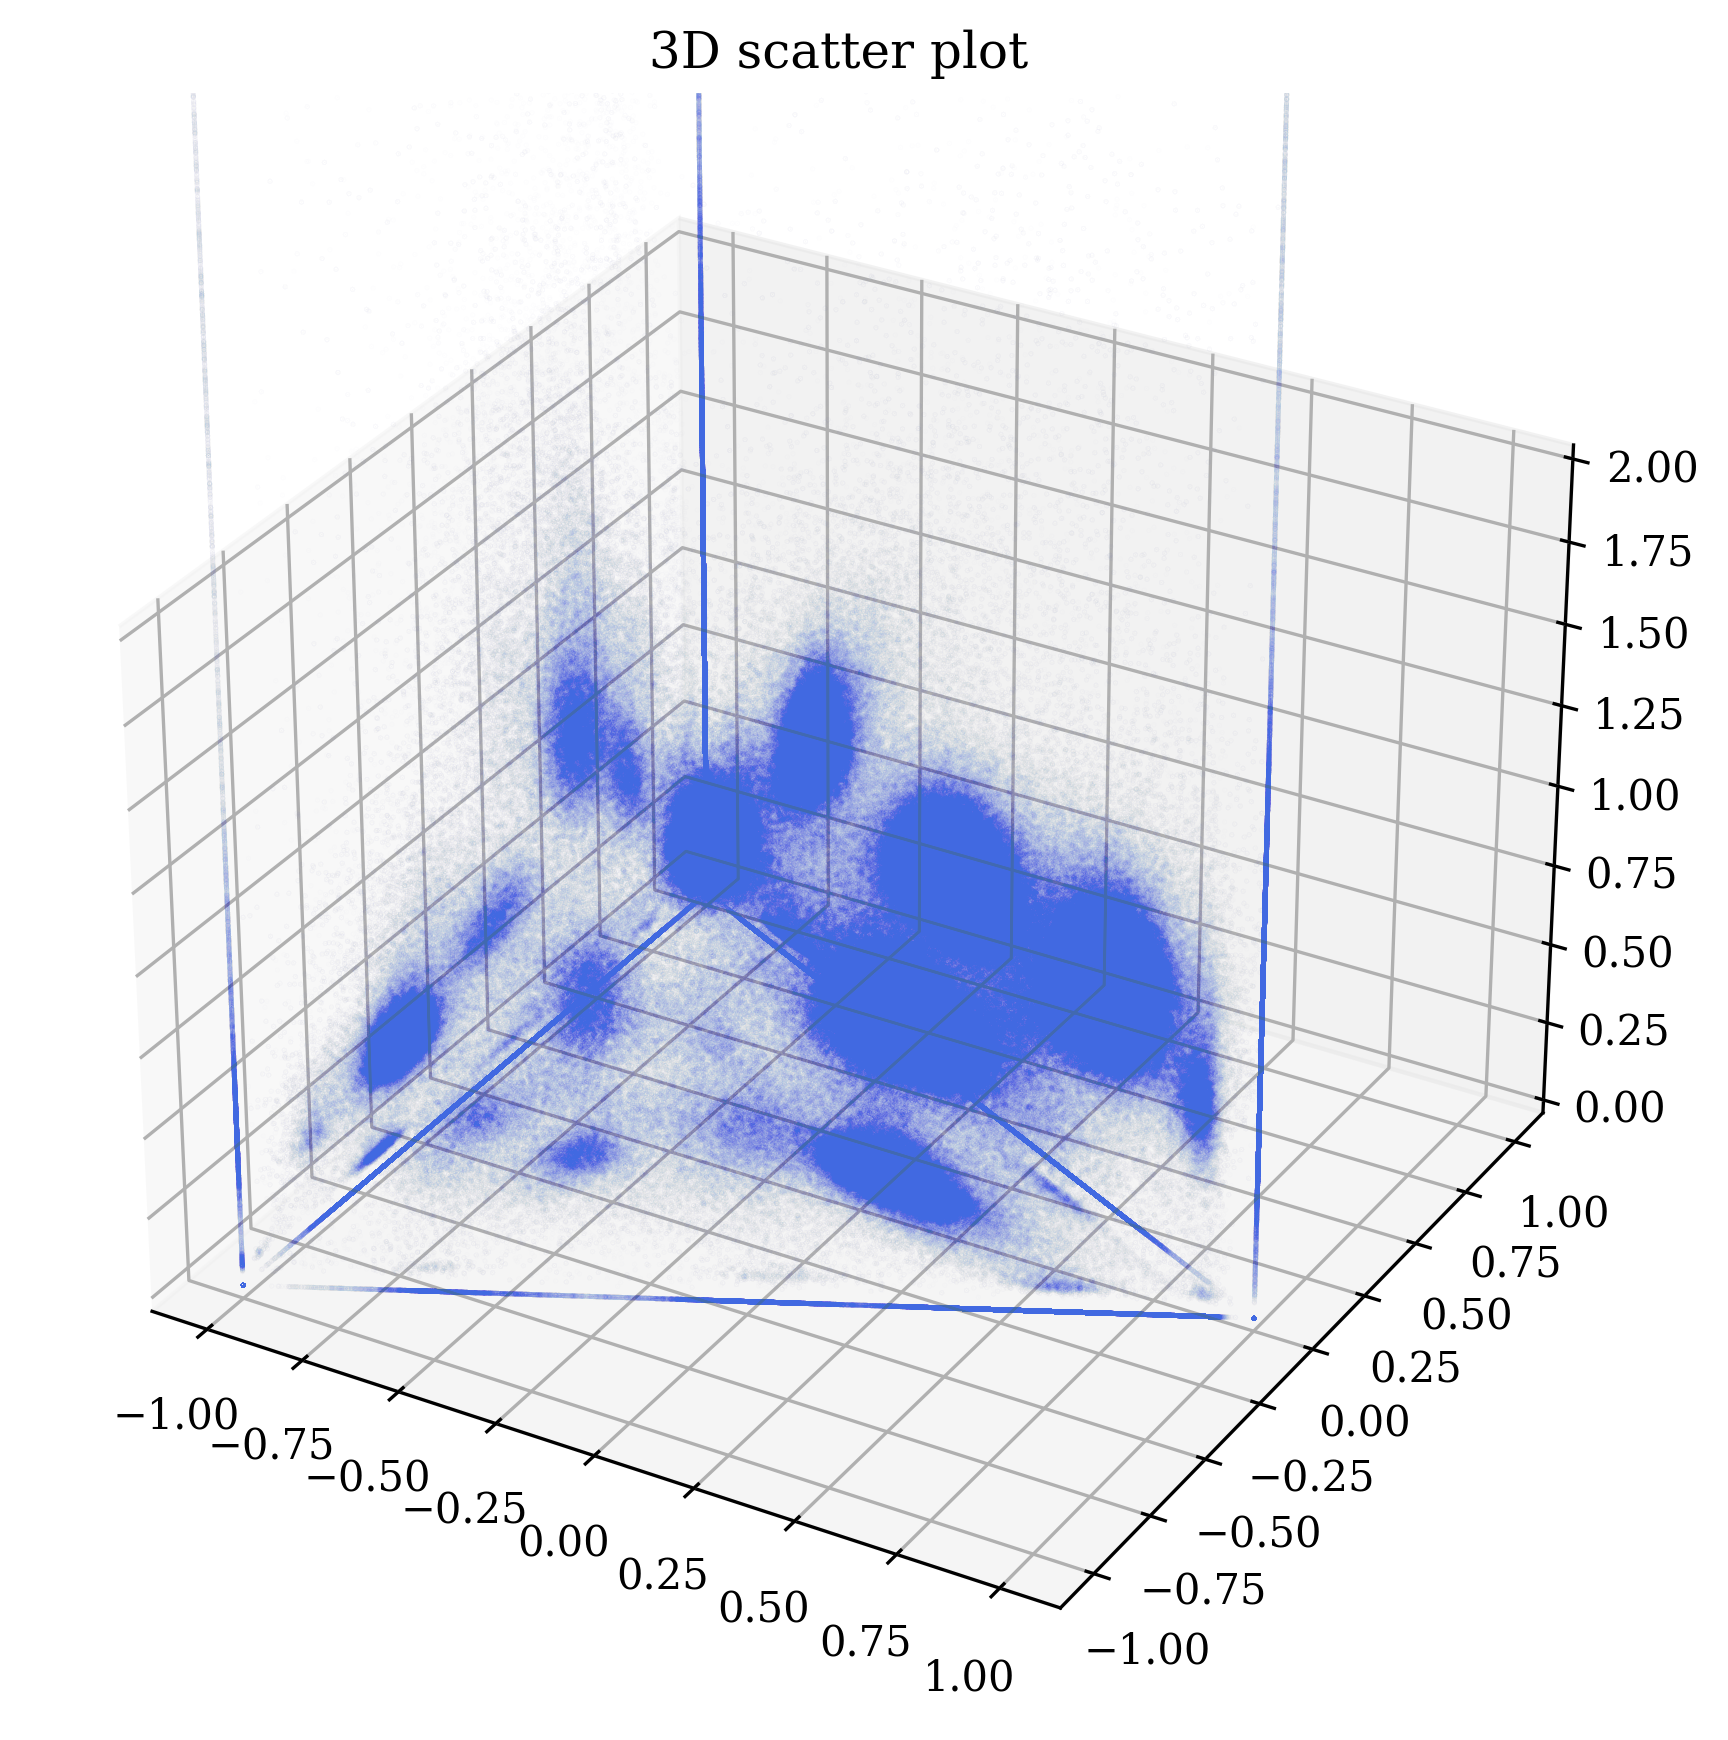

In [24]:
#3D plot
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(intensity_all['X_coor'], intensity_all['Y_coor'], intensity_all['G/A'], color = "royalblue",s=0.1,alpha=0.006)
ax.set_zlim3d(0,2)
plt.title("3D scatter plot")
plt.savefig(read_dir/'colorcoding_3D.jpg')

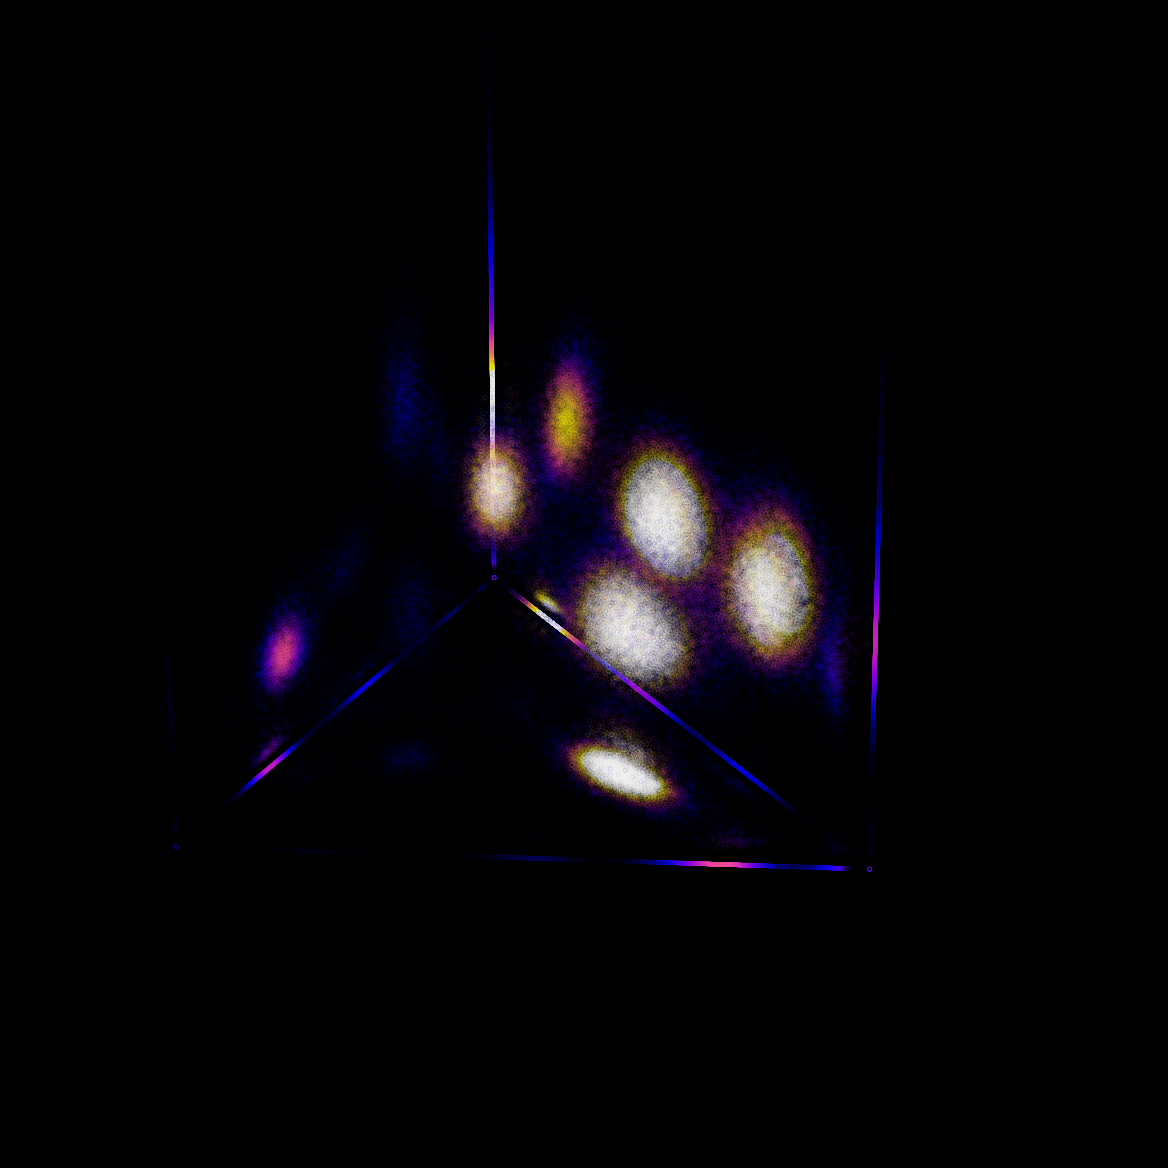

In [25]:
from scipy import stats

sample = intensity_all[['X_coor','Y_coor','G/A']].sample(frac=0.05,replace=True, random_state=1)
sample = sample[sample['G/A']<20]

mu, sigma = 0, 0.1 
x = np.array(sample['X_coor'])
y = np.array(sample['Y_coor'])
z = np.array(sample['G/A'])

xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=density, cmap=plt.cm.gnuplot2 ,s=0.0012,vmin=0, vmax=2)
ax.set_zlim3d(0,1.5)
fig.set_facecolor('black')
ax.set_facecolor('black') 
ax.grid(False) 
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_axis_off()
plt.savefig(read_dir/'3D_density_sampled_2.jpg')